In [1]:
%load_ext autoreload
%autoreload 2


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler

from einops import rearrange
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import math
import os, json
from typing import List,Tuple,Dict
from torch.nn.utils import prune

from turbpred.model_diffusion_blocks import Unet, ConvNextBlock
from turbpred.model import PredictionModel
from turbpred.turbulence_dataset import TurbulenceDataset
from turbpred.params import DataParams, TrainingParams, LossParams, ModelParamsEncoder, ModelParamsDecoder, ModelParamsLatent

In [2]:
modelName = "2D_Inc/128_unet-m2"
p_d = DataParams(batch=32, augmentations=["normalize"], sequenceLength=[2,2], randSeqOffset=True,
            dataSize=[104,52], dimension=2, simFields=["pres"], simParams=["rey"], normalizeMode="incMixed")
# p_d = DataParams(batch=32, augmentations=["normalize"], sequenceLength=[2,2], randSeqOffset=True,
#             dataSize=[128,64], dimension=2, simFields=["pres"], simParams=["rey"], normalizeMode="incMixed")

p_t = TrainingParams(epochs=1000, lr=0.0001)
p_l = LossParams(recMSE=0.0, predMSE=1.0)
p_me = None
p_ml = None

p_md2 = ModelParamsDecoder(arch="unet", pretrained=False, trainingNoise=0.0, convnext_mult=1)
# pretrainPath = "../runs/2D_Inc/128_unet-m2_17/Model.pth"
base_model = PredictionModel(p_d, p_t, p_l, p_me, p_md2, p_ml, "")


# Sparcity

In [3]:
def evaluate_sparcity(model):
    total_params = 0
    total_zeros = 0

    for name, module in model.named_modules():
        if hasattr(module, "weight"):
            num_params = sum(p.numel() for p in module.parameters())
            total_params += num_params
            total_zeros += torch.sum(module.weight == 0)

    return total_params, total_zeros.item()


In [4]:
def _prune(model:PredictionModel, prune_type:str, pruning_percentage:float):
    """ Prune Unet model """

    unet = model.modelDecoder
    conv_next_modules = [module for module in unet.modules() if type(module) is ConvNextBlock]
    
    if prune_type == 'L1':
        norm_n = 1
    elif prune_type == 'L2':
        norm_n = 2
    else:
        raise Exception("Wrong prune_type")

    for module in conv_next_modules:
        # We prune modules of ConvNextBlock that are scaled by convnext_mult 
        # module.net[1] --> Conv2D
        # module.net[3] --> GroupNorm
        # module.net[4] --> Conv2D
        
        prune.ln_structured(module.net[1], 'weight', amount=pruning_percentage, dim=0, n=norm_n)
        # prune.ln_structured(module.net[3], 'weight', amount=pruning_percentage, dim=1, n=norm_n)
        prune.ln_structured(module.net[4], 'weight', amount=pruning_percentage, dim=1, n=norm_n)


def prune_remove(model):
    unet = model.modelDecoder
    for name, module in unet.named_modules():
        if type(module) is ConvNextBlock:
            # print(name)
            prune.remove(module.net[1], 'weight')
            prune.remove(module.net[4], 'weight')

In [5]:
p_md = ModelParamsDecoder(arch="unet", pretrained=False, trainingNoise=0.0, convnext_mult=4)
pruned_pretrainPath = "../runs/2D_Inc/128_unet-m2_07/Model.pth"
pruned_model = PredictionModel(p_d, p_t, p_l, p_me, p_md, p_ml, pruned_pretrainPath)

In [56]:
total_params, spar = evaluate_sparcity(base_model)
print(f"Base model, {total_params} params, sparcity: {spar}")

total_params, spar = evaluate_sparcity(pruned_model)
print(f"Pruned model, {total_params} params, sparcity: {(spar/total_params):.2f}%, non-zero:{total_params-spar}")

Base model, 3856096 params, sparcity: 0
Pruned model, 11944072 params, sparcity: 0.00%, non-zero:11944072


In [57]:
total_params, spar = evaluate_sparcity(pruned_model)
print(f"Pruned model, {total_params} params, sparcity: {spar/total_params:.2f}")

for i in range(14):
    _prune(pruned_model, "L2", 0.1)
prune_remove(pruned_model)

total_params, spar = evaluate_sparcity(pruned_model)
print(f"Pruned model, {total_params} params, sparcity: {(spar/total_params):.2f}, non-zeros: {total_params - spar}")

Pruned model, 11944072 params, sparcity: 0.00
Pruned model, 11944072 params, sparcity: 0.70, non-zeros: 3635308


In [21]:
mods = [x for x in pruned_model.modelDecoder.modules() if type(x) is ConvNextBlock]

weights = [w for n, w in mods[0].net[4].named_parameters() if n == "weight"][0]
# print(weights.shape)

In [88]:
loadedPretrainedWeightDict = torch.load(pruned_pretrainPath)
pruned_model.modelDecoder.load_state_dict(loadedPretrainedWeightDict["stateDictDecoder"])

evaluate_sparcity(pruned_model)

(13888056, 5675904)

In [17]:
for name, p in pruned_model.named_parameters():
    print(name, type(p).__name__)

modelDecoder.init_conv.weight Parameter
modelDecoder.init_conv.bias Parameter
modelDecoder.downs.0.0.ds_conv.weight Parameter
modelDecoder.downs.0.0.ds_conv.bias Parameter
modelDecoder.downs.0.0.net.0.weight Parameter
modelDecoder.downs.0.0.net.0.bias Parameter
modelDecoder.downs.0.0.net.1.weight Parameter
modelDecoder.downs.0.0.net.1.bias Parameter
modelDecoder.downs.0.0.net.3.weight Parameter
modelDecoder.downs.0.0.net.3.bias Parameter
modelDecoder.downs.0.0.net.4.weight Parameter
modelDecoder.downs.0.0.net.4.bias Parameter
modelDecoder.downs.0.0.res_conv.weight Parameter
modelDecoder.downs.0.0.res_conv.bias Parameter
modelDecoder.downs.0.1.ds_conv.weight Parameter
modelDecoder.downs.0.1.ds_conv.bias Parameter
modelDecoder.downs.0.1.net.0.weight Parameter
modelDecoder.downs.0.1.net.0.bias Parameter
modelDecoder.downs.0.1.net.1.weight Parameter
modelDecoder.downs.0.1.net.1.bias Parameter
modelDecoder.downs.0.1.net.3.weight Parameter
modelDecoder.downs.0.1.net.3.bias Parameter
modelDec

In [45]:
prune_remove(pruned_model)

downs.0.0
downs.0.1
downs.1.0
downs.1.1
downs.2.0
downs.2.1
ups.0.0
ups.0.1
ups.1.0
ups.1.1
mid_block1
mid_block2
final_conv.0


In [18]:
nparams, nzeros = evaluate_sparcity(pruned_model)
nparams, nzeros, nparams - nzeros

(13888056, 5675904, 8212152)

In [52]:
evaluate_sparcity(base_model)


(5721912, 0)

In [4]:
p_d = DataParams(batch=32, augmentations=["normalize", "resize"], sequenceLength=[2,2], randSeqOffset=True,
            dataSize=[64,32], dimension=2, simFields=["pres"], simParams=["rey"], normalizeMode="incMixed")



In [8]:
# base_model.modelDecoder.
inChannels = (p_d.dimension + len(p_d.simFields) + len(p_d.simParams))
outChannels = p_d.dimension + len(p_d.simFields) + len(p_d.simParams)
inChannels, outChannels 

(4, 4)

In [9]:
model_prova = Unet(dim=64, out_dim=outChannels, channels=inChannels, dim_mults=(1,1,1), use_convnext=True, convnext_mult=1, with_time_emb=False)

In [10]:
evaluate_sparcity(model_prova)

(1560222, 1)

In [19]:
model_prova

Unet(
  (init_conv): Conv2d(4, 42, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (downs): ModuleList(
    (0): ModuleList(
      (0): ConvNextBlock(
        (ds_conv): Conv2d(42, 42, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=42)
        (net): Sequential(
          (0): GroupNorm(1, 42, eps=1e-05, affine=True)
          (1): Conv2d(42, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): GELU(approximate='none')
          (3): GroupNorm(1, 64, eps=1e-05, affine=True)
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (res_conv): Conv2d(42, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): ConvNextBlock(
        (ds_conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
        (net): Sequential(
          (0): GroupNorm(1, 64, eps=1e-05, affine=True)
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): GELU(approximate='

init_conv.weight Parameter


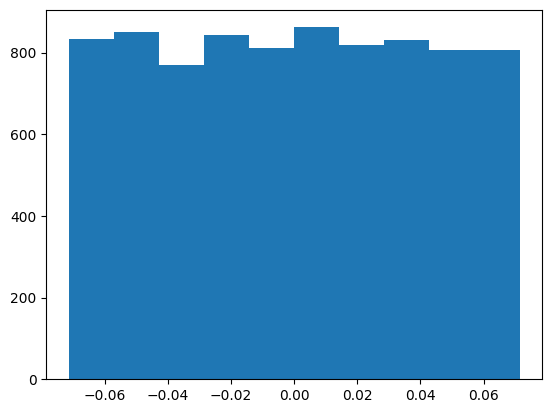

init_conv.bias Parameter


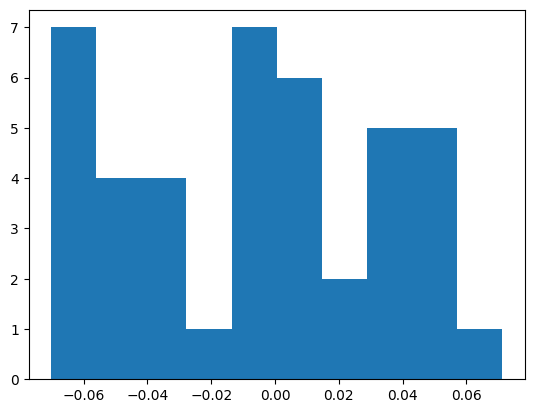

downs.0.0.ds_conv.weight Parameter


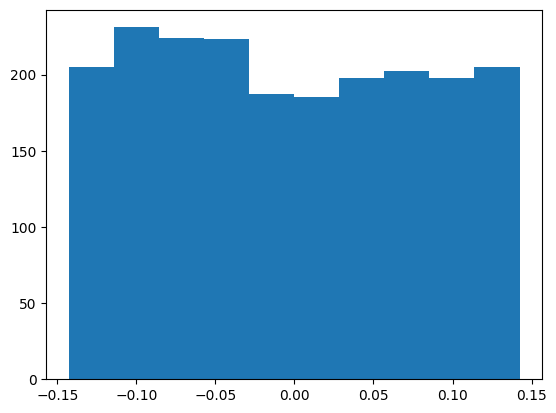

downs.0.0.ds_conv.bias Parameter


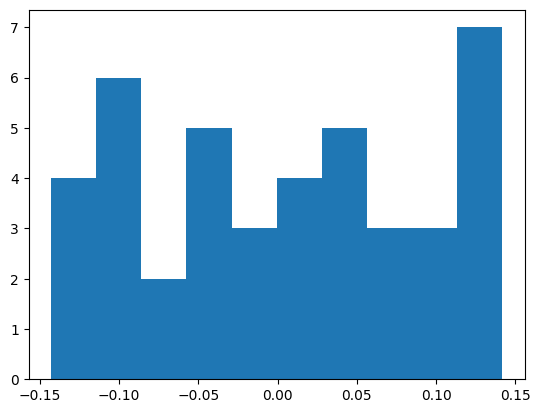

downs.0.0.net.0.weight Parameter


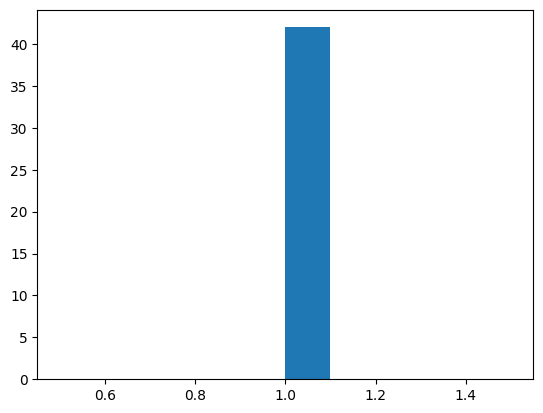

downs.0.0.net.0.bias Parameter


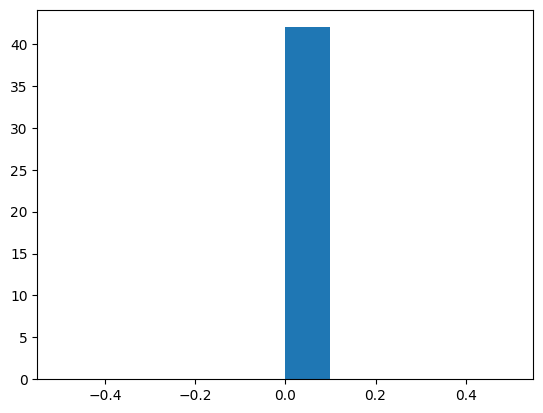

downs.0.0.net.1.weight Parameter


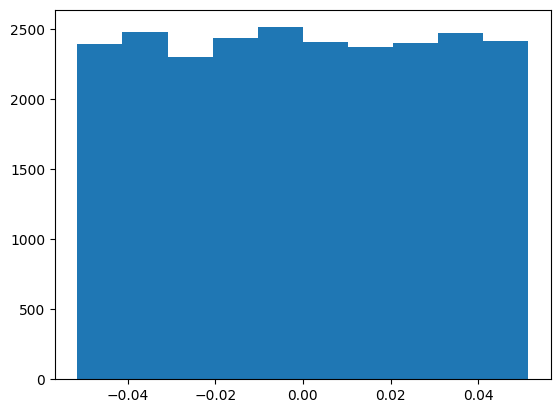

downs.0.0.net.1.bias Parameter


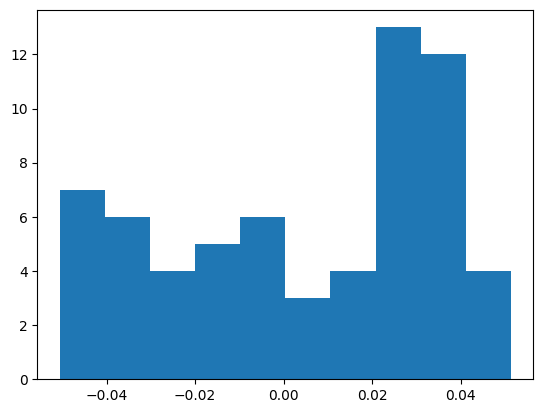

downs.0.0.net.3.weight Parameter


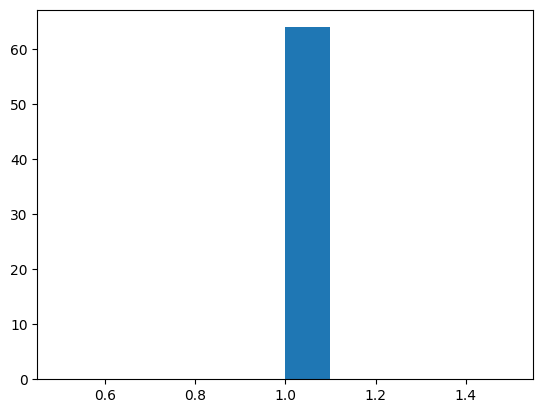

downs.0.0.net.3.bias Parameter


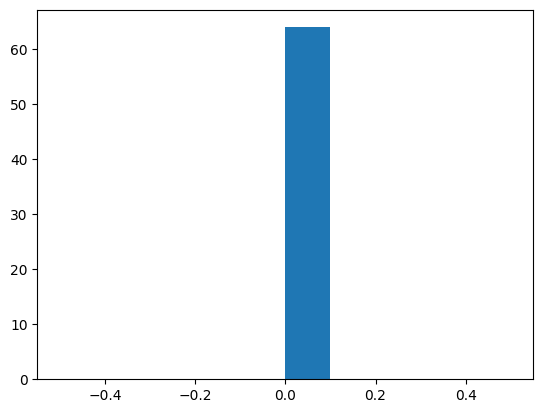

downs.0.0.net.4.weight Parameter


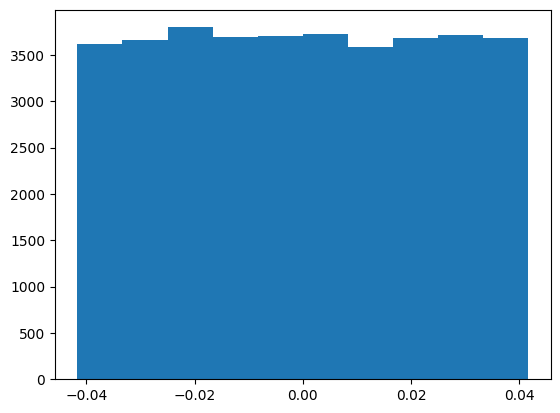

downs.0.0.net.4.bias Parameter


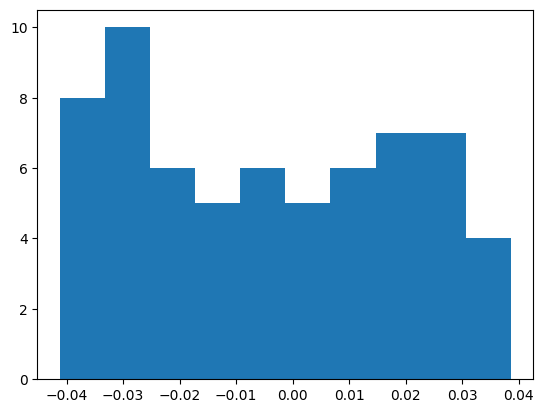

downs.0.0.res_conv.weight Parameter


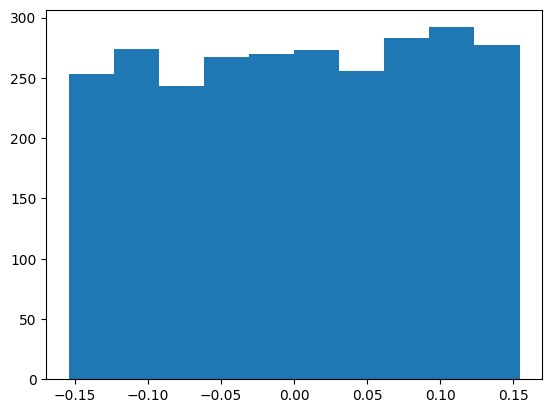

downs.0.0.res_conv.bias Parameter


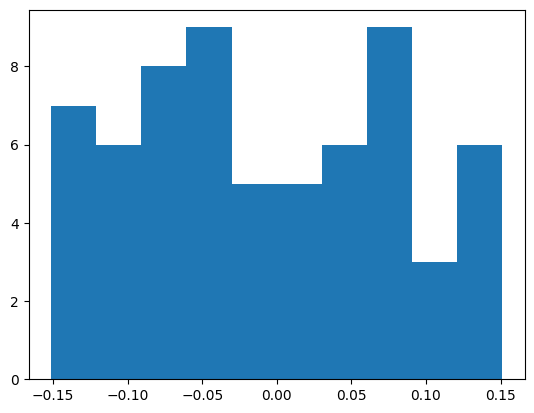

downs.0.1.ds_conv.weight Parameter


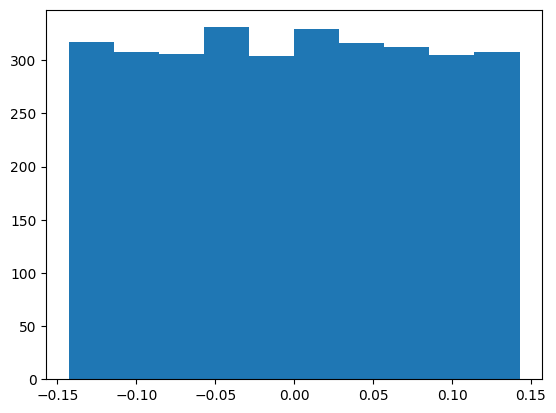

downs.0.1.ds_conv.bias Parameter


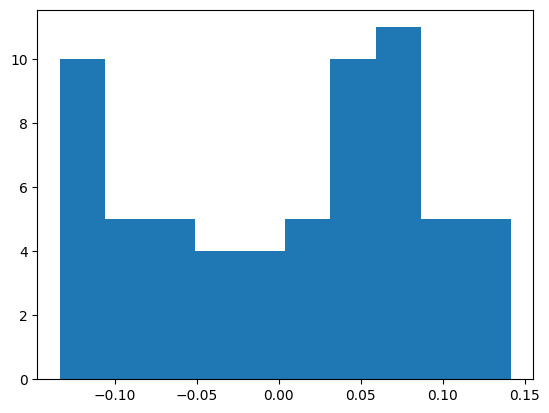

downs.0.1.net.0.weight Parameter


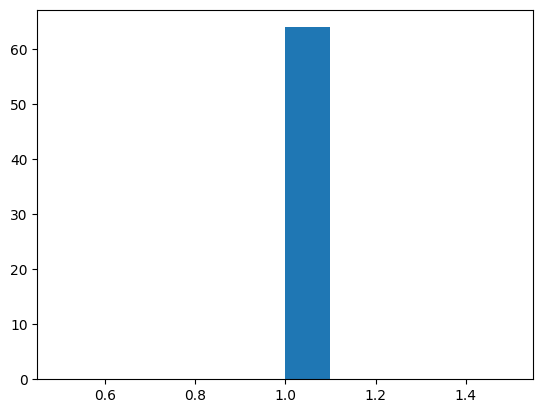

downs.0.1.net.0.bias Parameter


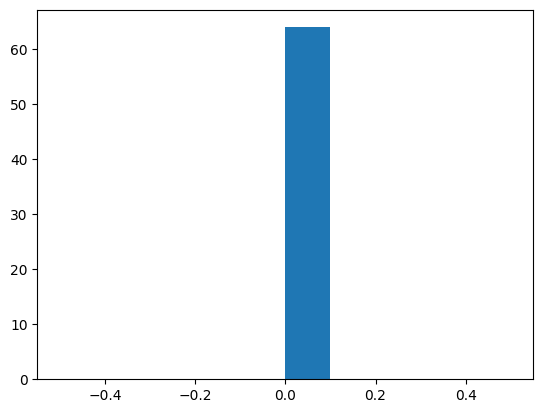

downs.0.1.net.1.weight Parameter


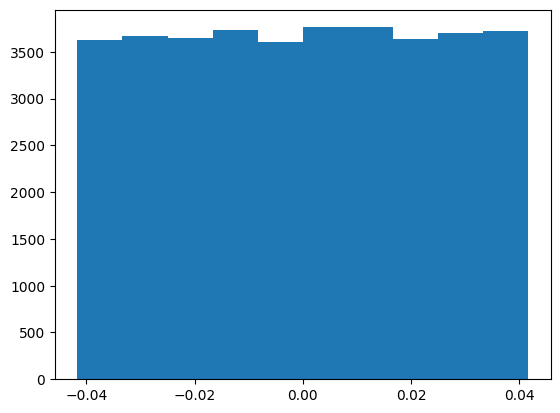

downs.0.1.net.1.bias Parameter


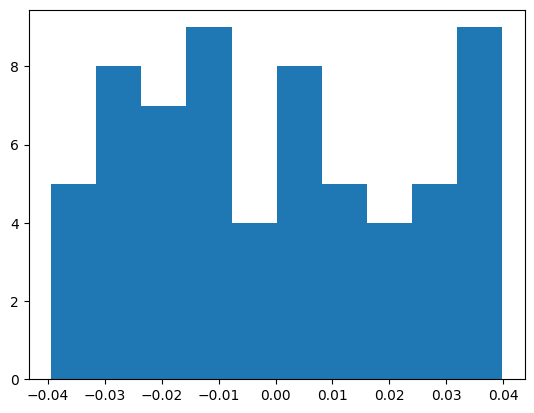

downs.0.1.net.3.weight Parameter


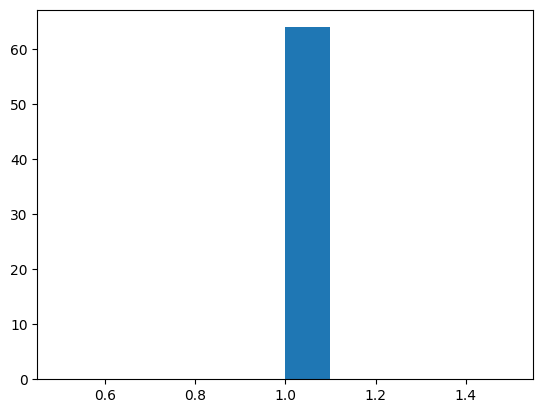

downs.0.1.net.3.bias Parameter


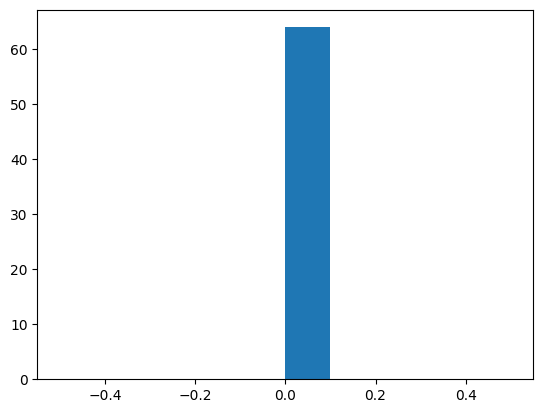

downs.0.1.net.4.weight Parameter


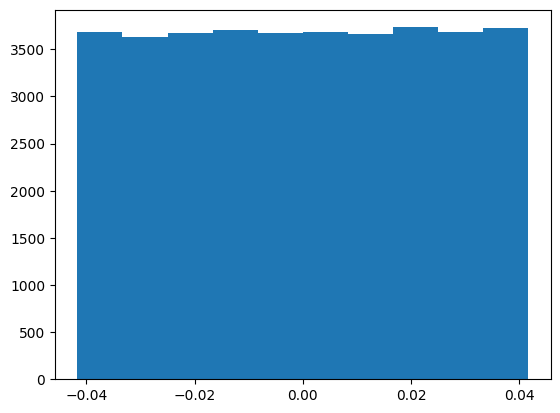

downs.0.1.net.4.bias Parameter


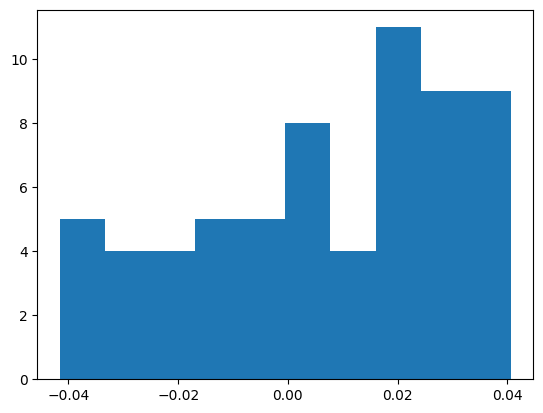

downs.0.2.fn.fn.to_qkv.weight Parameter


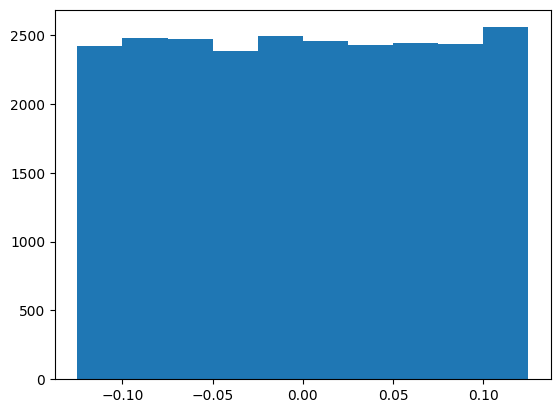

downs.0.2.fn.fn.to_out.0.weight Parameter


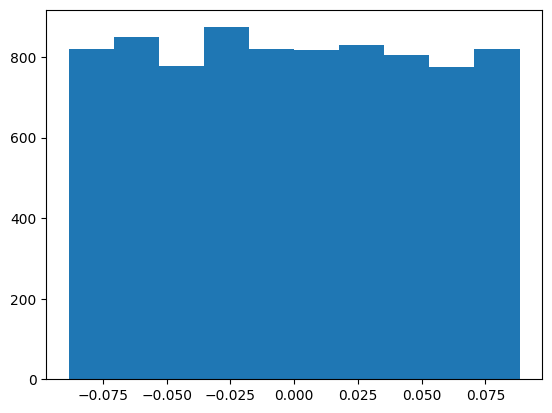

downs.0.2.fn.fn.to_out.0.bias Parameter


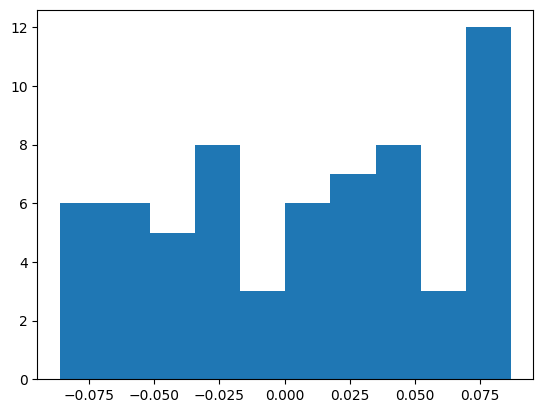

downs.0.2.fn.fn.to_out.1.weight Parameter


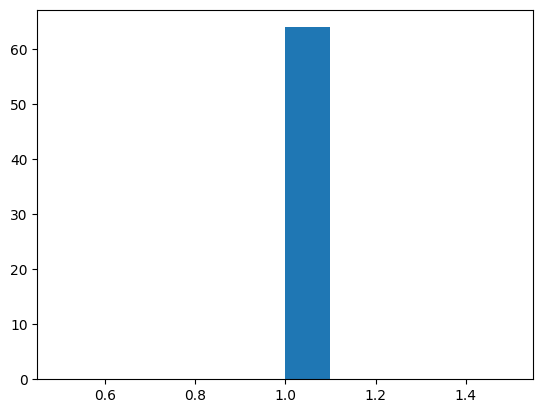

downs.0.2.fn.fn.to_out.1.bias Parameter


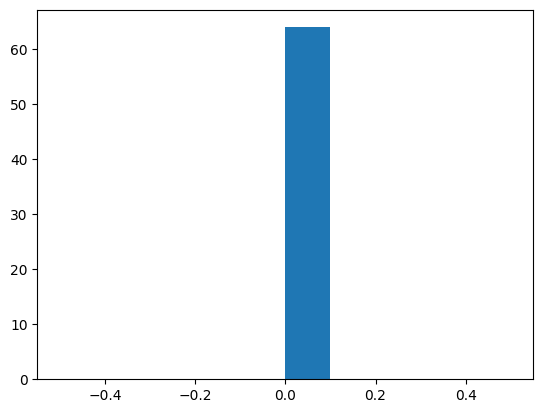

downs.0.2.fn.norm.weight Parameter


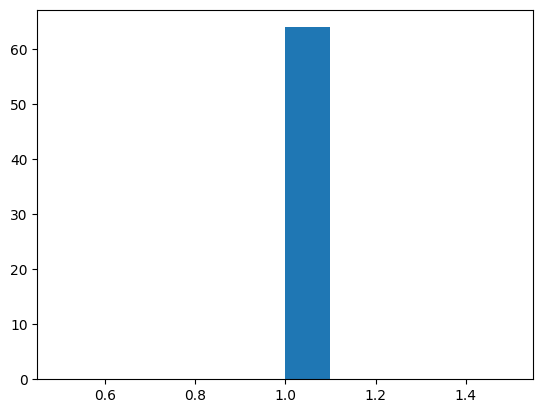

downs.0.2.fn.norm.bias Parameter


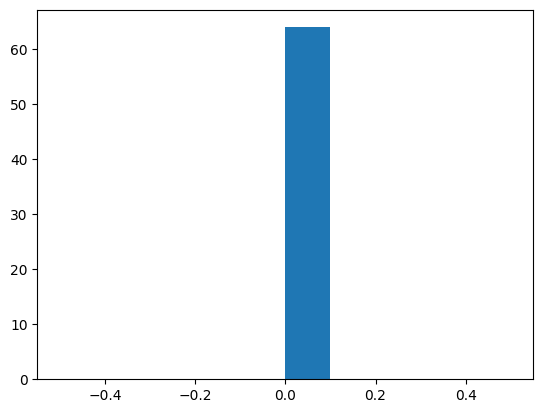

downs.0.3.weight Parameter


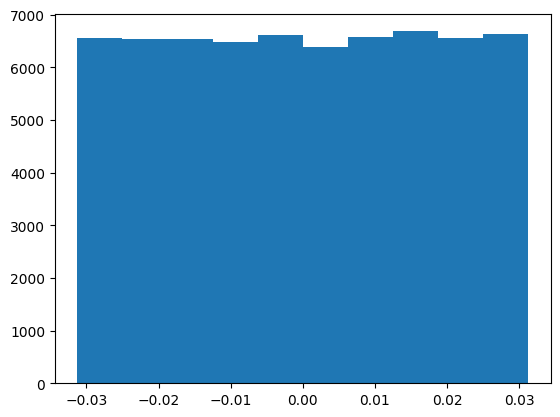

downs.0.3.bias Parameter


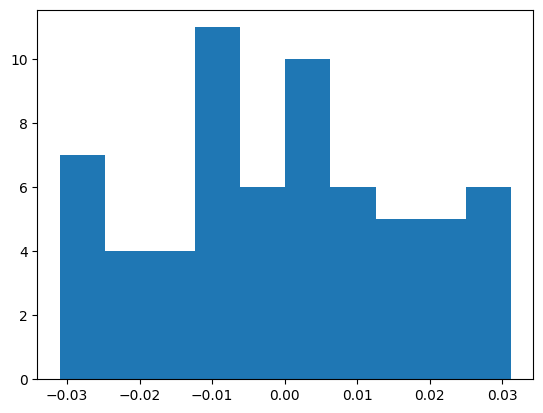

downs.1.0.ds_conv.weight Parameter


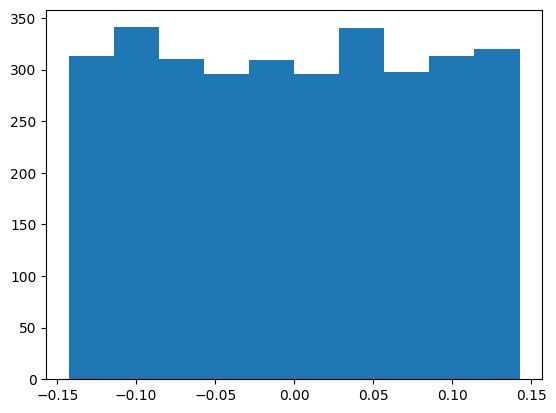

downs.1.0.ds_conv.bias Parameter


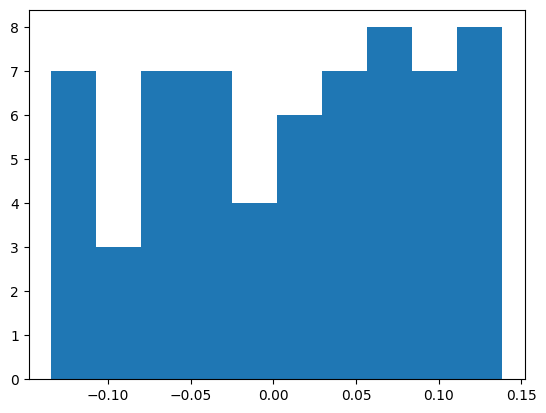

downs.1.0.net.0.weight Parameter


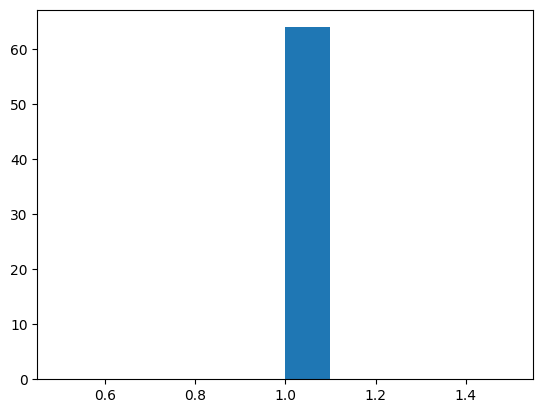

downs.1.0.net.0.bias Parameter


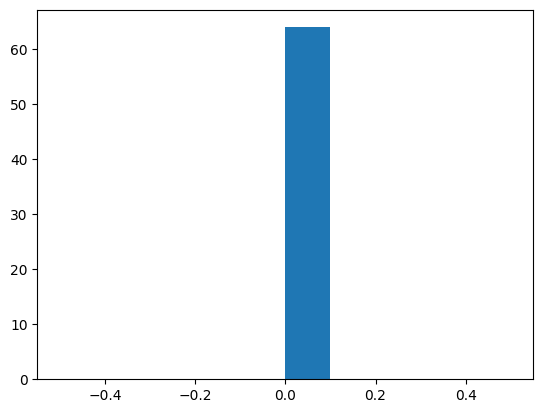

downs.1.0.net.1.weight Parameter


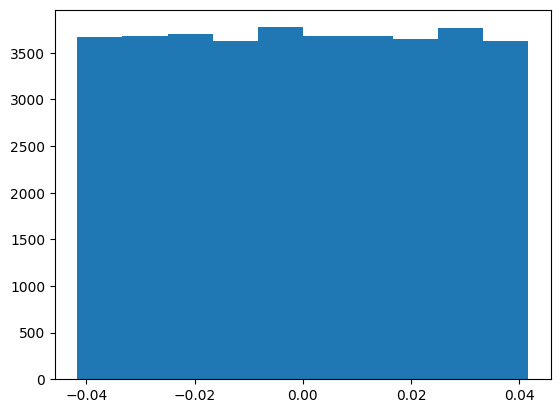

downs.1.0.net.1.bias Parameter


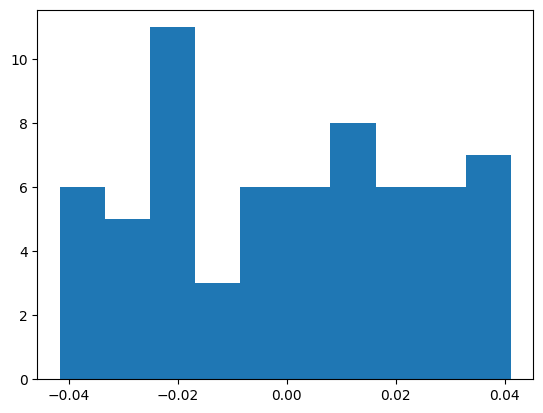

downs.1.0.net.3.weight Parameter


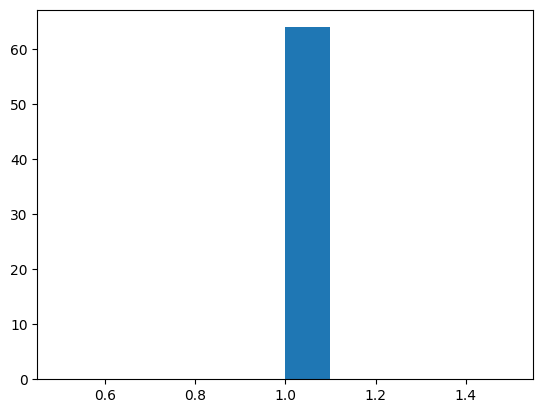

downs.1.0.net.3.bias Parameter


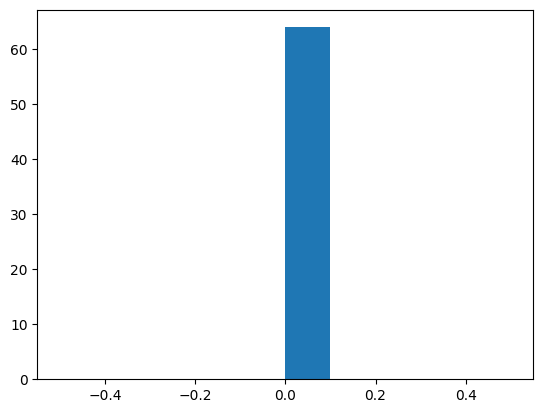

downs.1.0.net.4.weight Parameter


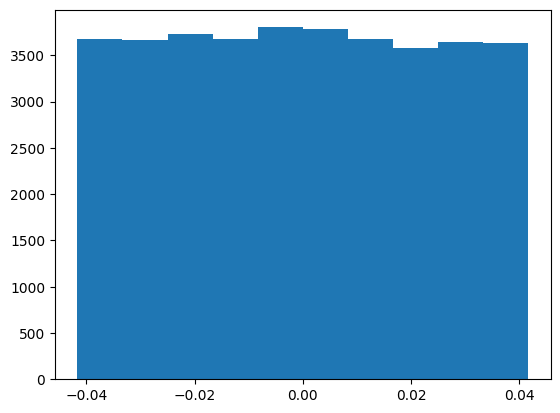

downs.1.0.net.4.bias Parameter


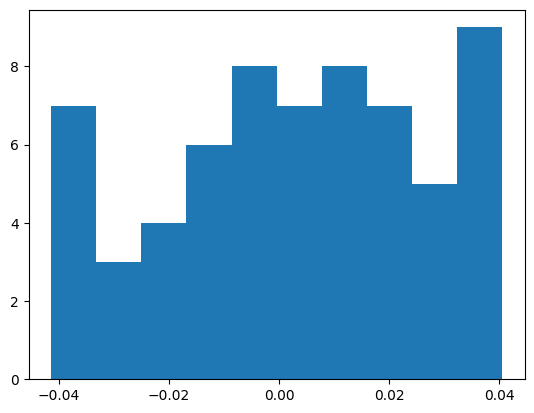

downs.1.1.ds_conv.weight Parameter


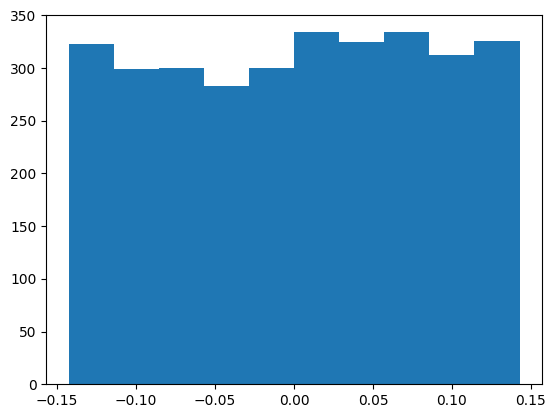

downs.1.1.ds_conv.bias Parameter


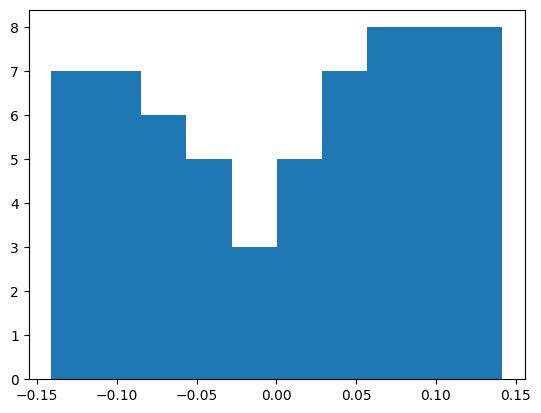

downs.1.1.net.0.weight Parameter


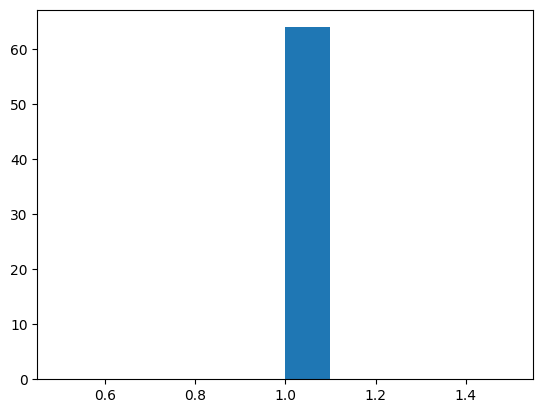

downs.1.1.net.0.bias Parameter


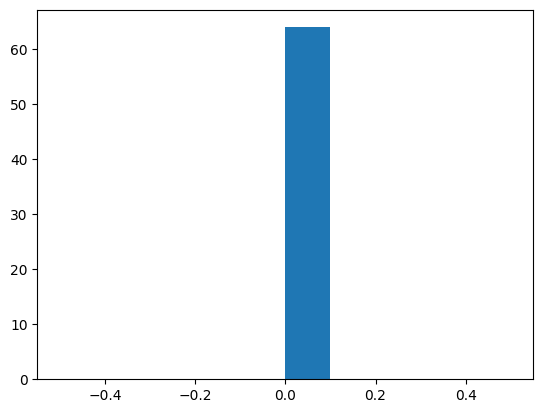

downs.1.1.net.1.weight Parameter


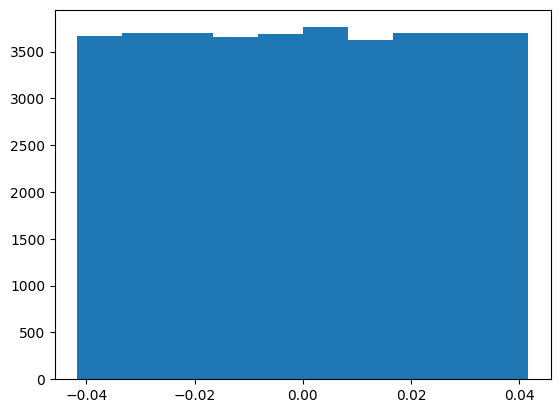

downs.1.1.net.1.bias Parameter


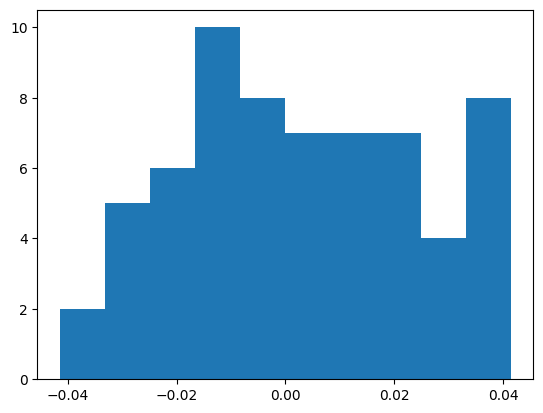

downs.1.1.net.3.weight Parameter


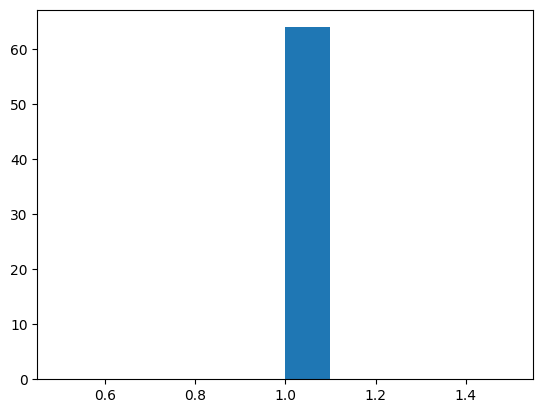

downs.1.1.net.3.bias Parameter


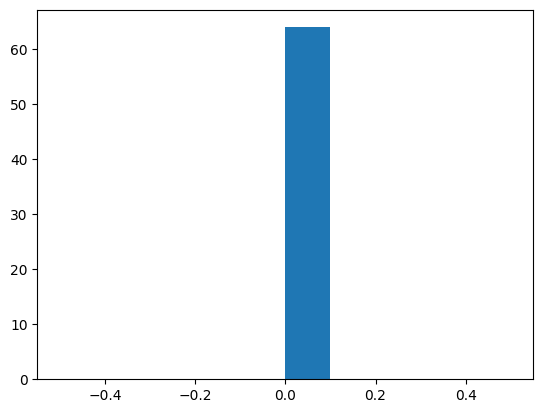

downs.1.1.net.4.weight Parameter


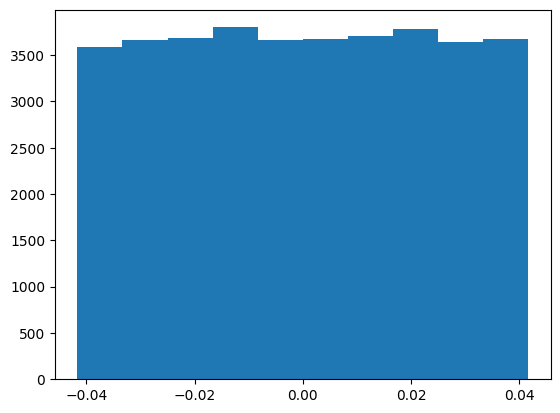

downs.1.1.net.4.bias Parameter


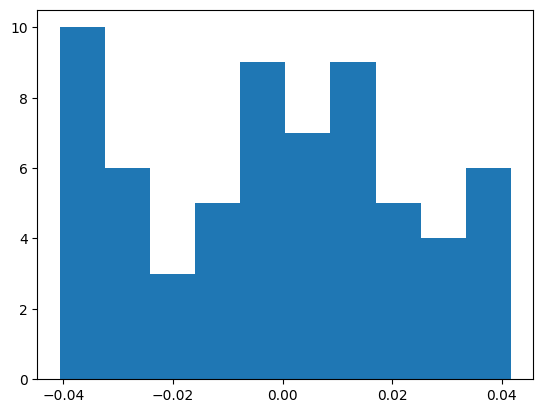

downs.1.2.fn.fn.to_qkv.weight Parameter


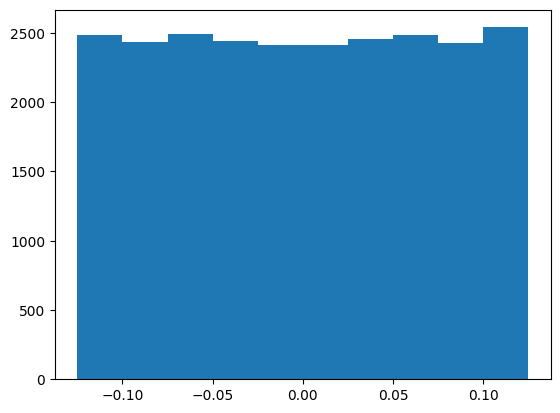

downs.1.2.fn.fn.to_out.0.weight Parameter


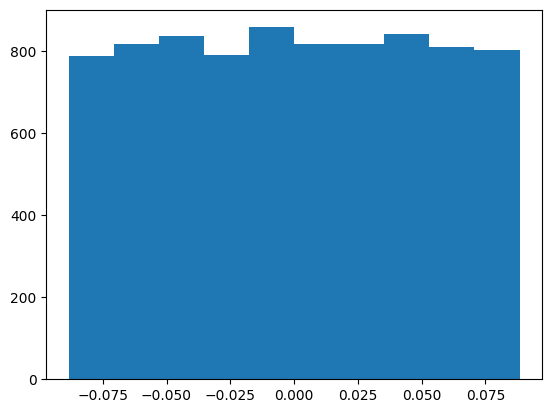

downs.1.2.fn.fn.to_out.0.bias Parameter


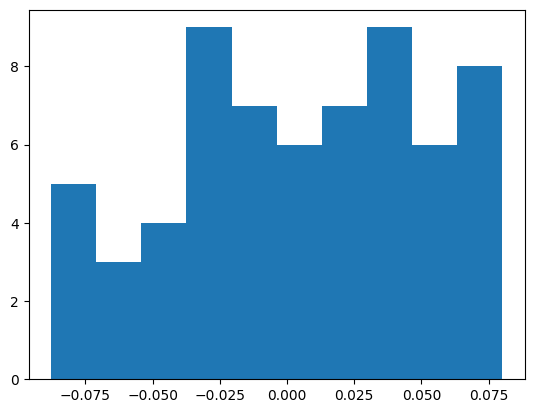

downs.1.2.fn.fn.to_out.1.weight Parameter


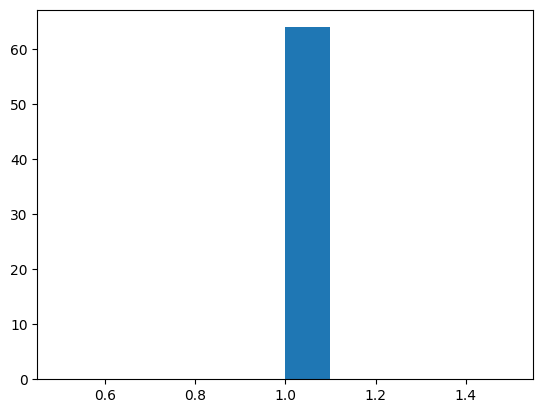

downs.1.2.fn.fn.to_out.1.bias Parameter


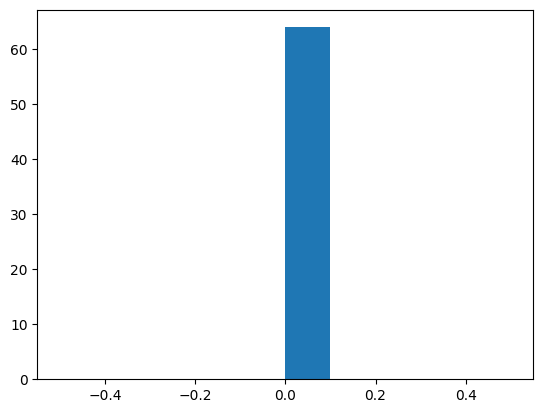

downs.1.2.fn.norm.weight Parameter


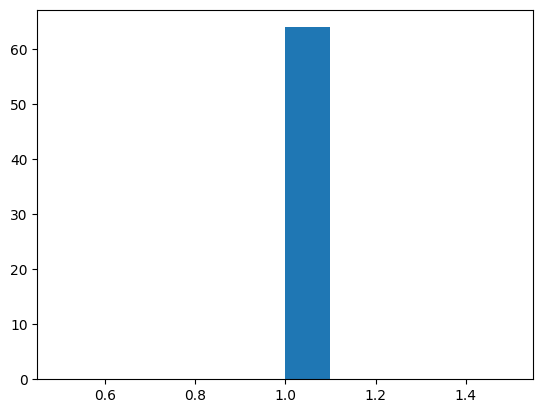

downs.1.2.fn.norm.bias Parameter


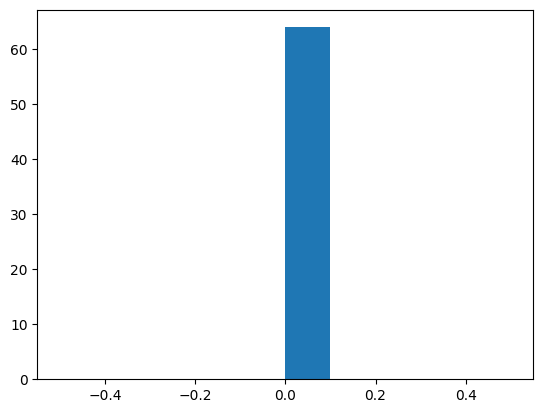

downs.1.3.weight Parameter


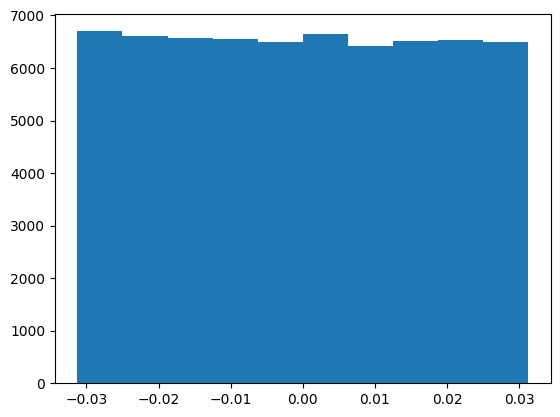

downs.1.3.bias Parameter


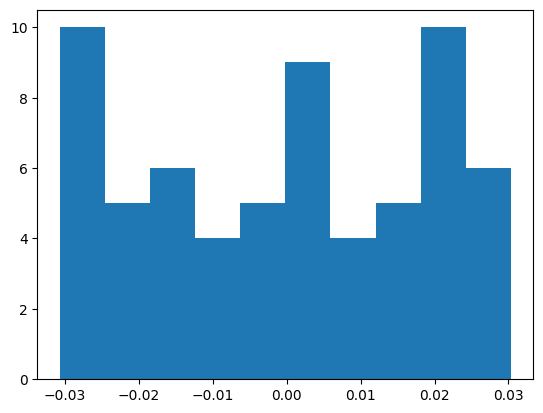

downs.2.0.ds_conv.weight Parameter


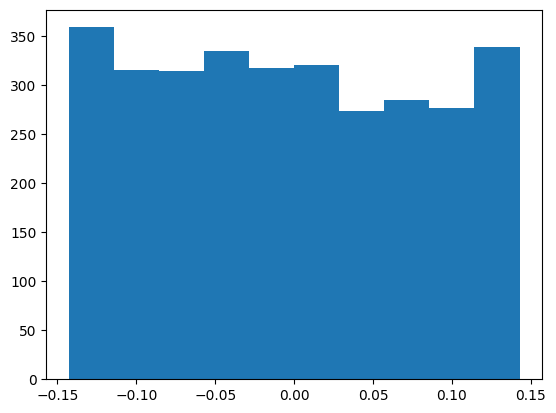

downs.2.0.ds_conv.bias Parameter


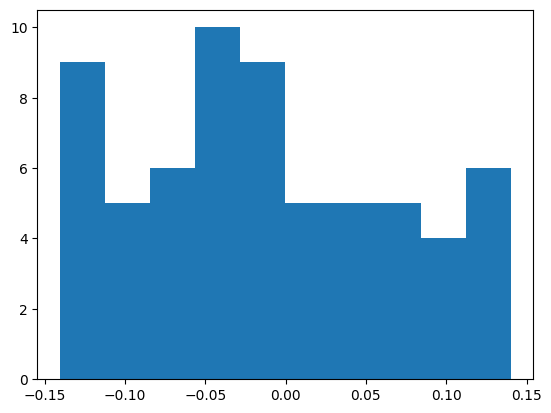

downs.2.0.net.0.weight Parameter


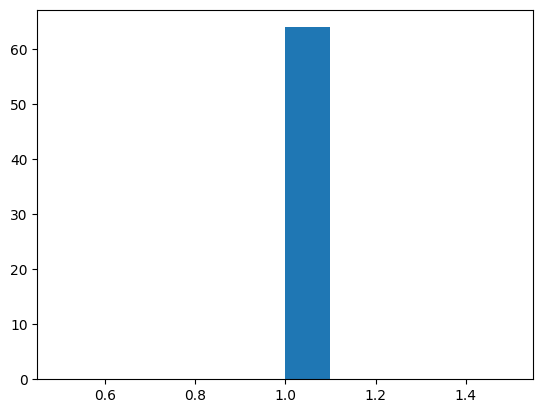

downs.2.0.net.0.bias Parameter


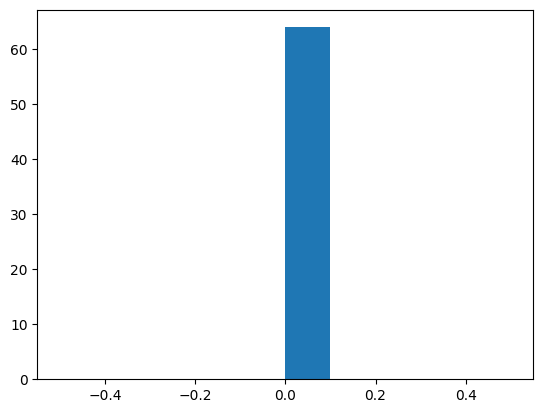

downs.2.0.net.1.weight Parameter


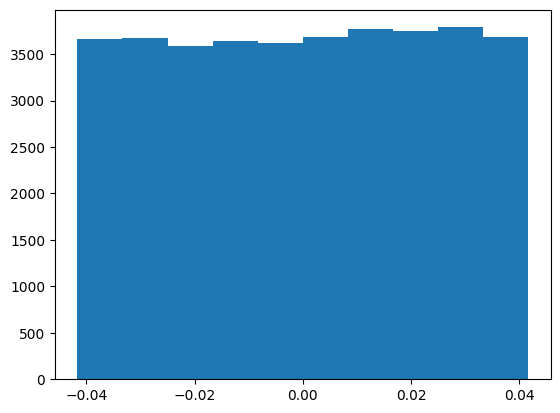

downs.2.0.net.1.bias Parameter


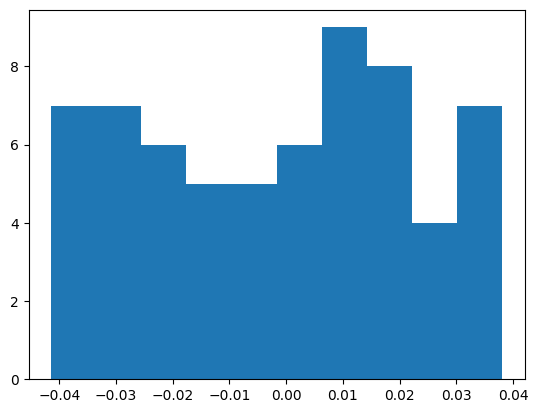

downs.2.0.net.3.weight Parameter


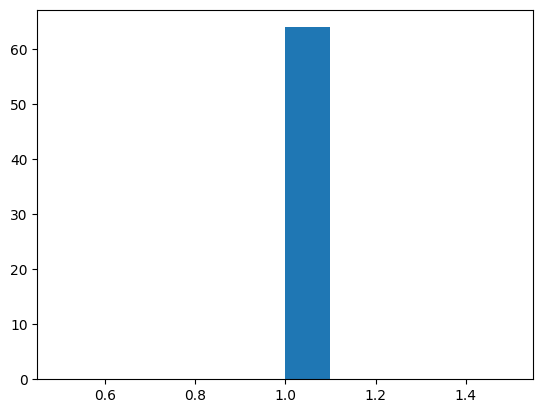

downs.2.0.net.3.bias Parameter


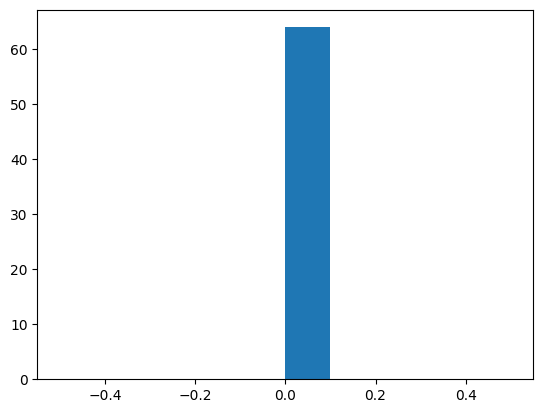

downs.2.0.net.4.weight Parameter


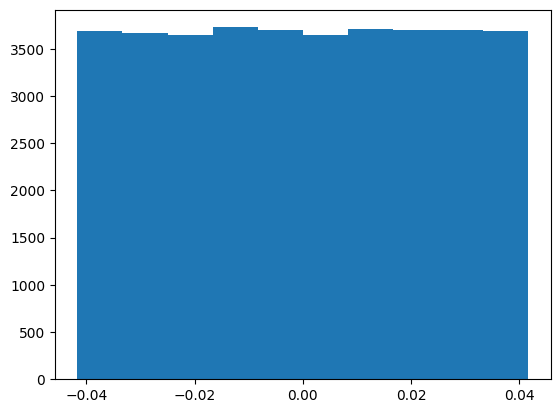

downs.2.0.net.4.bias Parameter


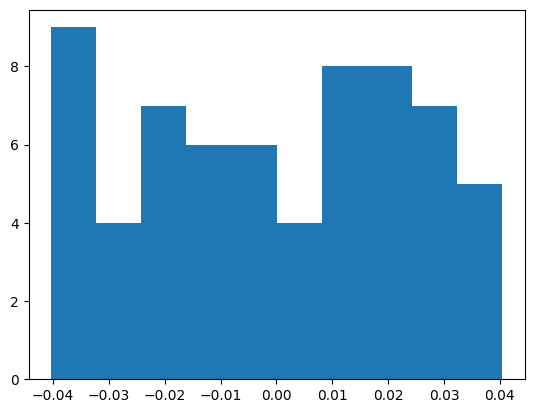

downs.2.1.ds_conv.weight Parameter


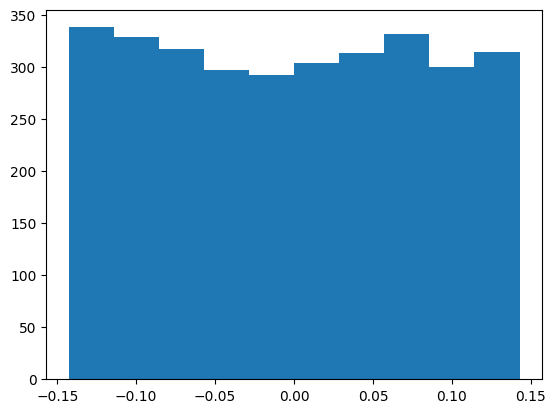

downs.2.1.ds_conv.bias Parameter


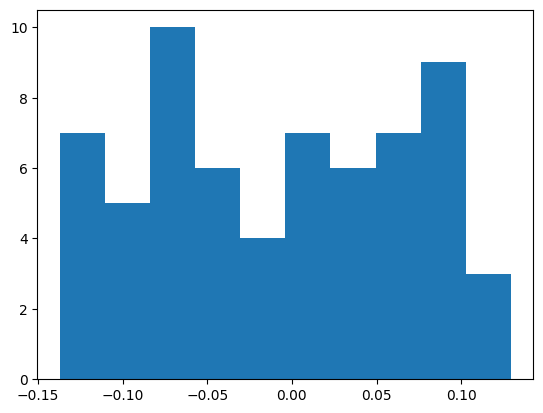

downs.2.1.net.0.weight Parameter


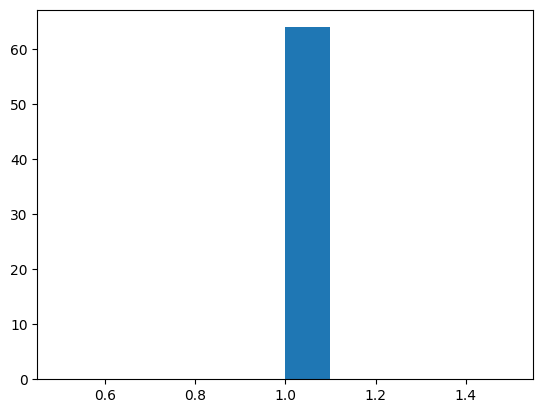

downs.2.1.net.0.bias Parameter


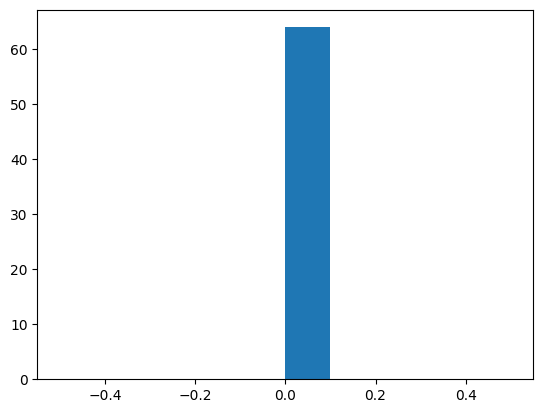

downs.2.1.net.1.weight Parameter


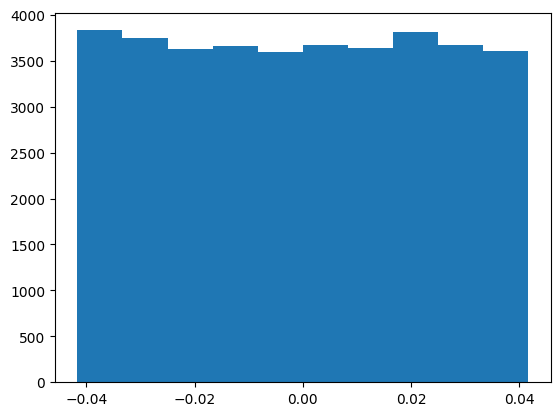

downs.2.1.net.1.bias Parameter


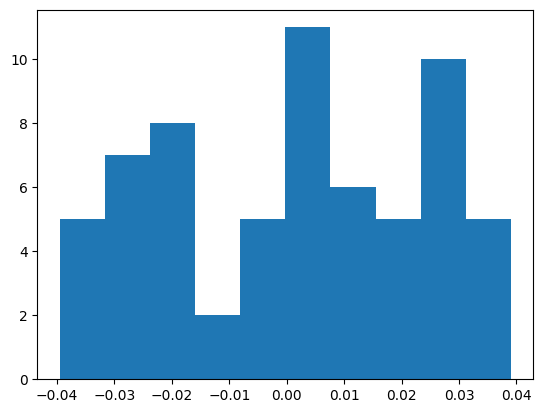

downs.2.1.net.3.weight Parameter


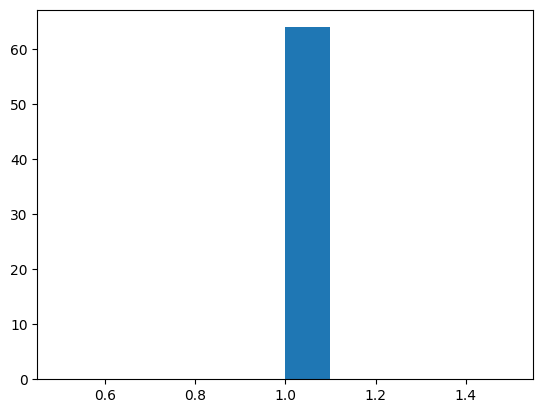

downs.2.1.net.3.bias Parameter


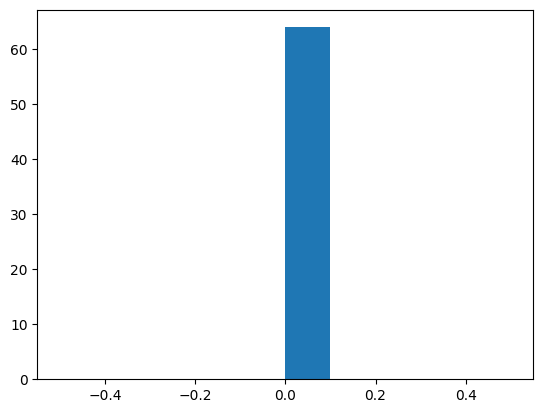

downs.2.1.net.4.weight Parameter


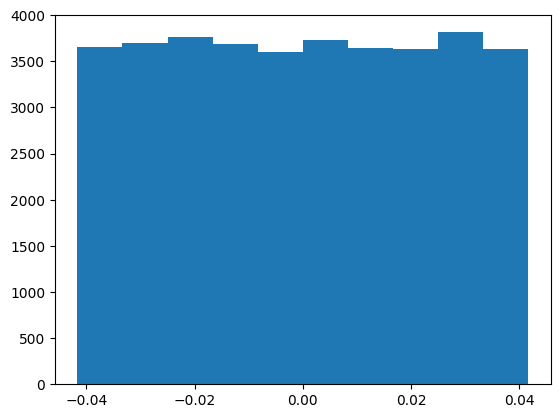

downs.2.1.net.4.bias Parameter


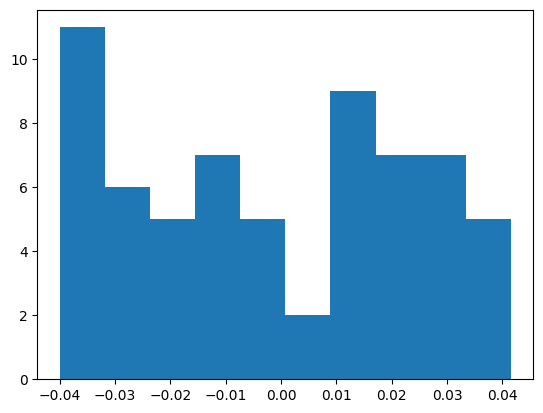

downs.2.2.fn.fn.to_qkv.weight Parameter


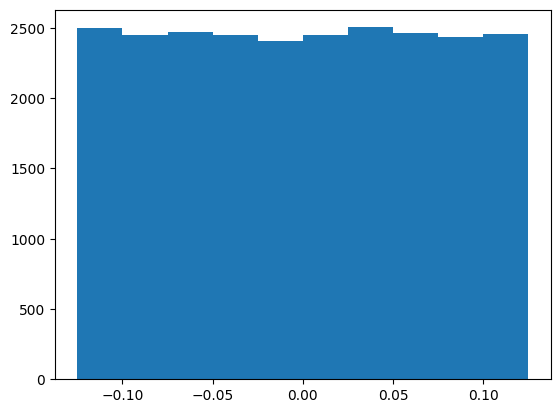

downs.2.2.fn.fn.to_out.0.weight Parameter


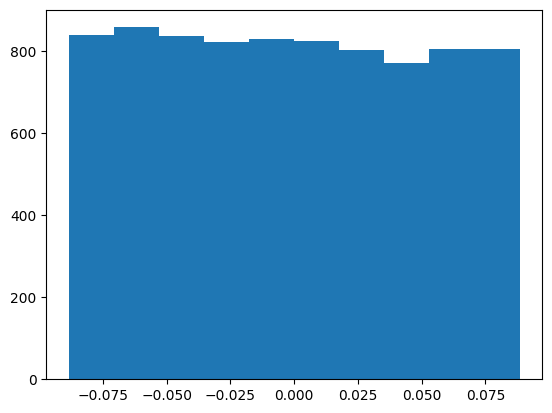

downs.2.2.fn.fn.to_out.0.bias Parameter


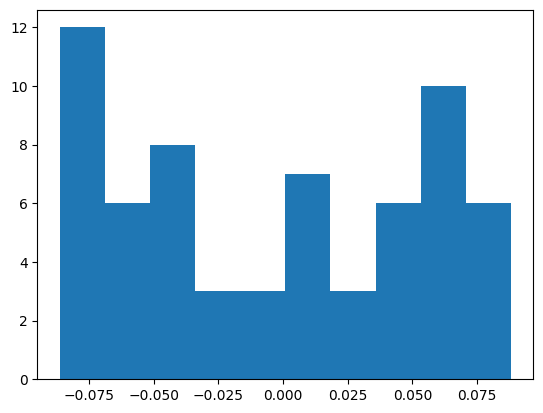

downs.2.2.fn.fn.to_out.1.weight Parameter


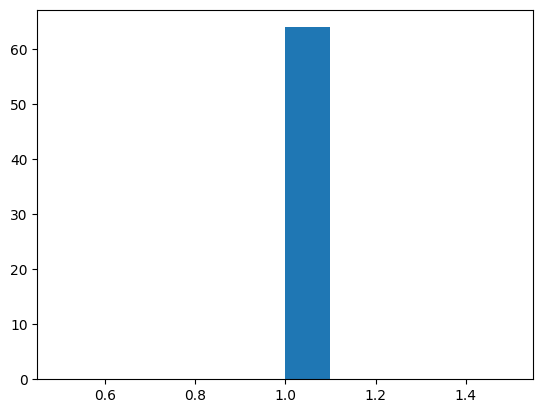

downs.2.2.fn.fn.to_out.1.bias Parameter


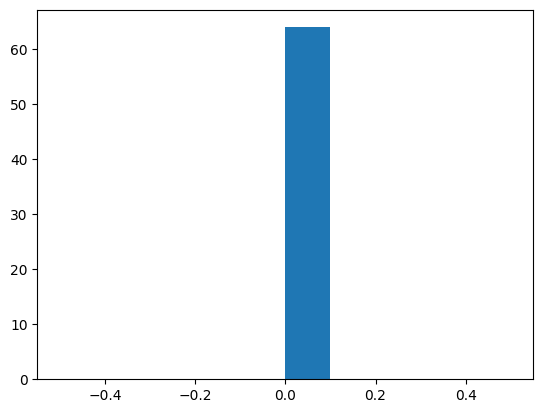

downs.2.2.fn.norm.weight Parameter


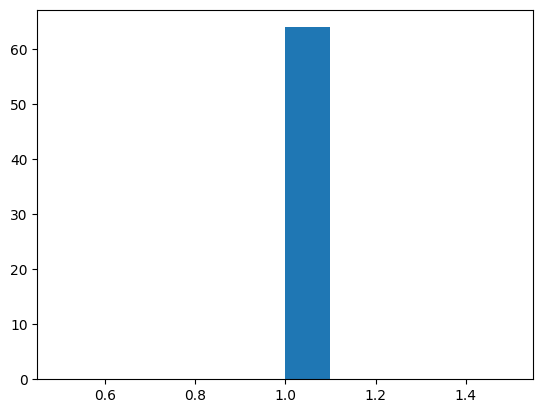

downs.2.2.fn.norm.bias Parameter


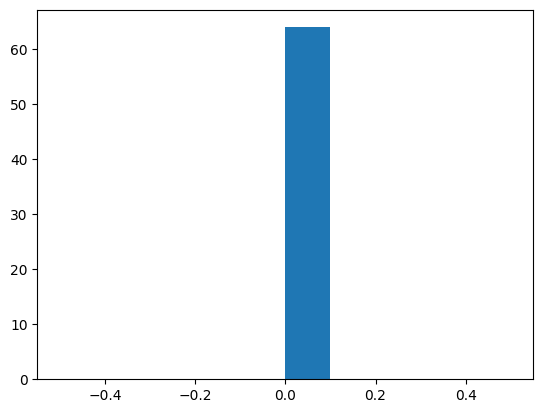

ups.0.0.ds_conv.weight Parameter


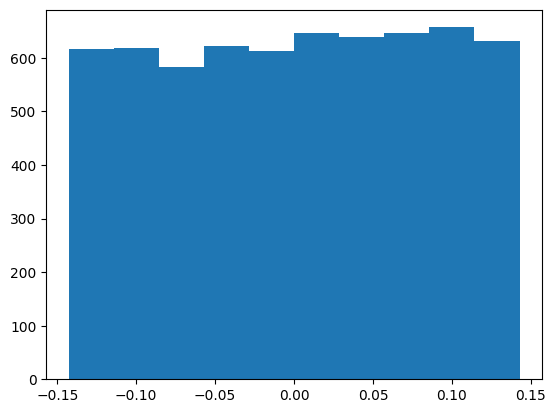

ups.0.0.ds_conv.bias Parameter


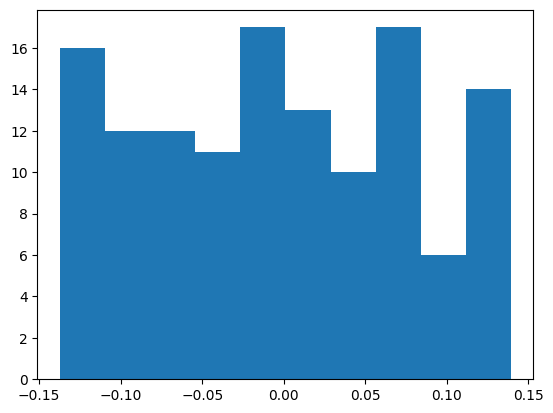

ups.0.0.net.0.weight Parameter


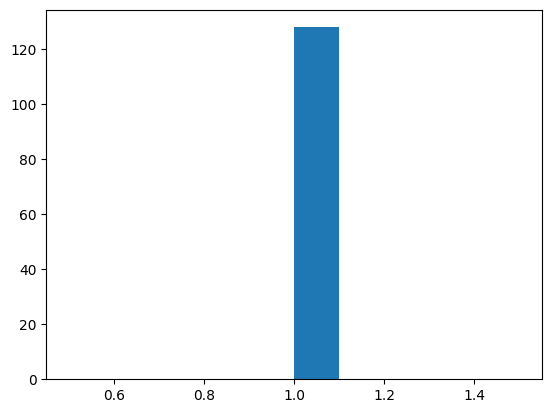

ups.0.0.net.0.bias Parameter


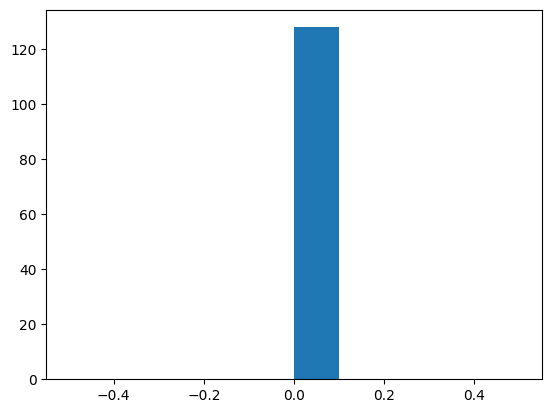

ups.0.0.net.1.weight Parameter


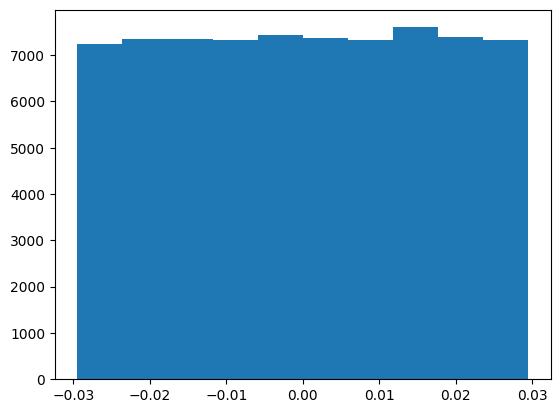

ups.0.0.net.1.bias Parameter


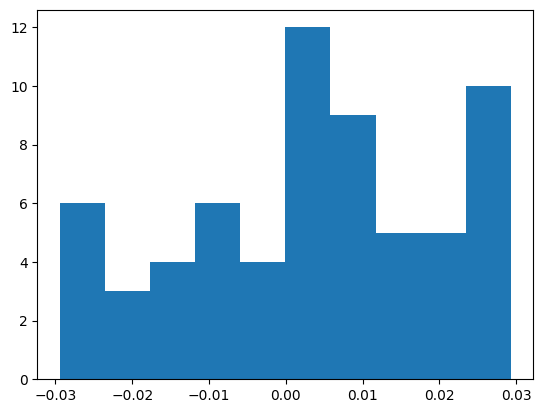

ups.0.0.net.3.weight Parameter


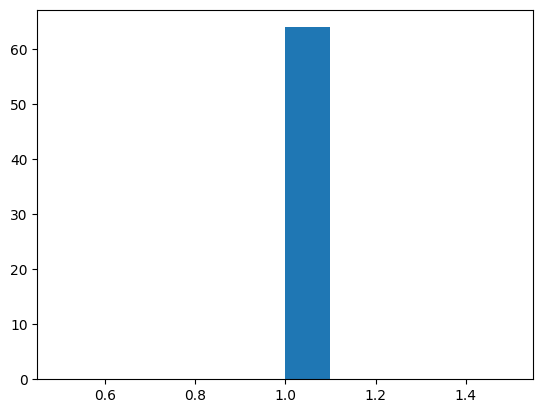

ups.0.0.net.3.bias Parameter


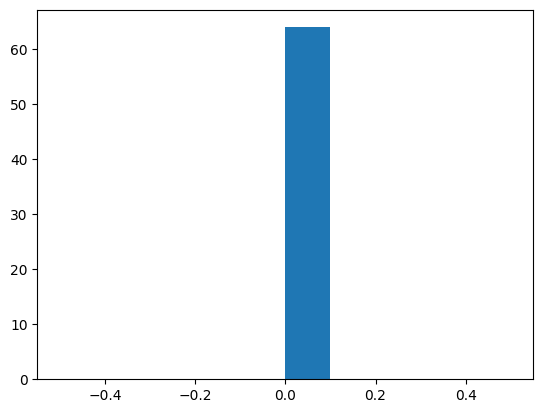

ups.0.0.net.4.weight Parameter


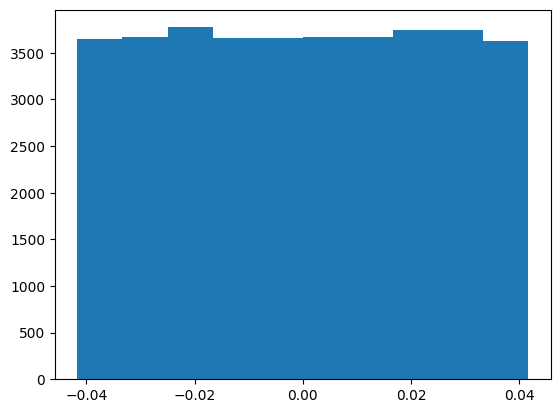

ups.0.0.net.4.bias Parameter


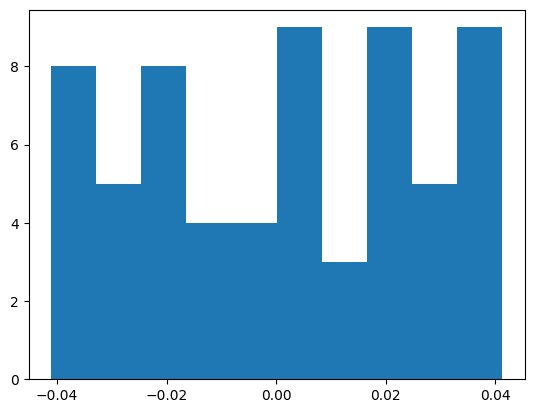

ups.0.0.res_conv.weight Parameter


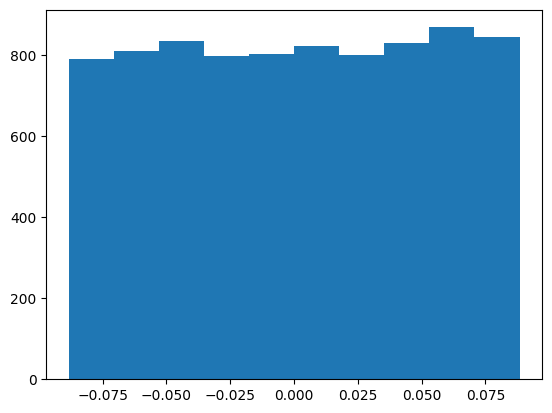

ups.0.0.res_conv.bias Parameter


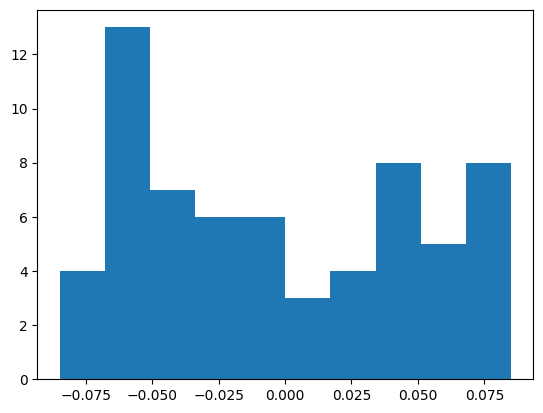

ups.0.1.ds_conv.weight Parameter


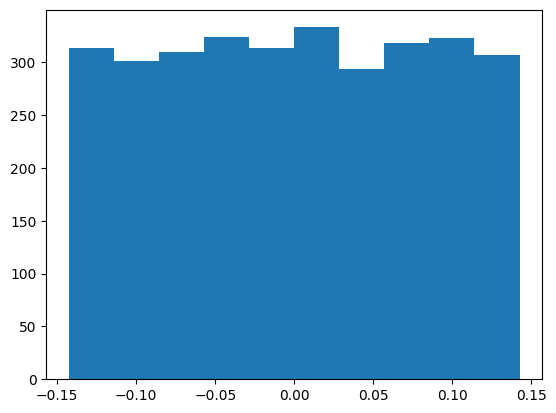

ups.0.1.ds_conv.bias Parameter


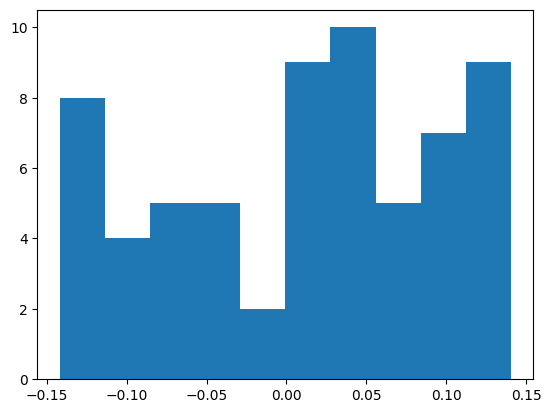

ups.0.1.net.0.weight Parameter


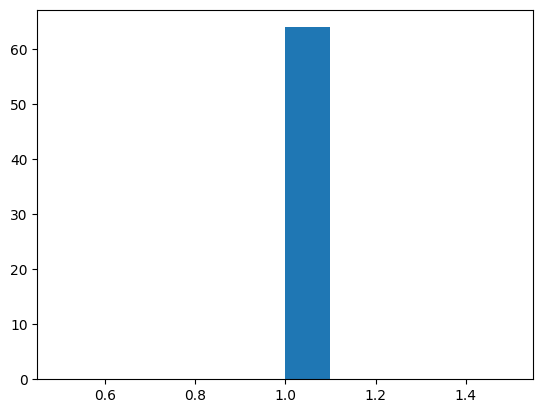

ups.0.1.net.0.bias Parameter


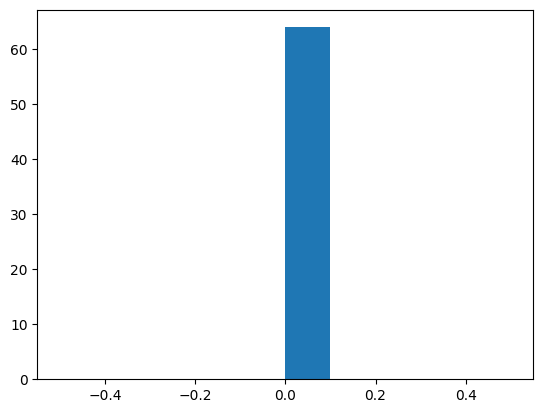

ups.0.1.net.1.weight Parameter


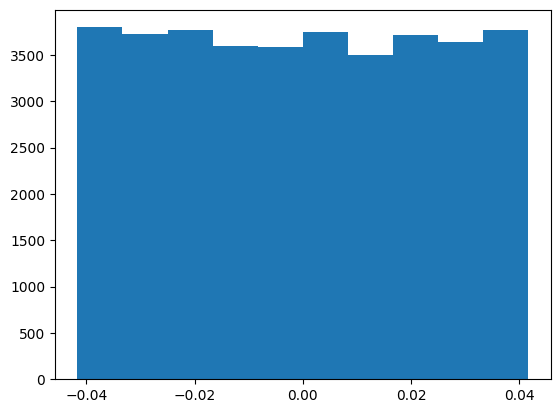

ups.0.1.net.1.bias Parameter


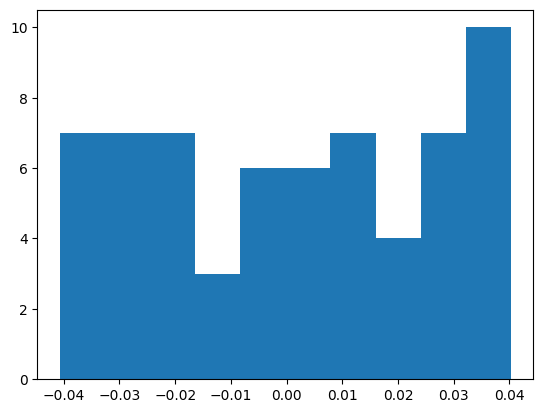

ups.0.1.net.3.weight Parameter


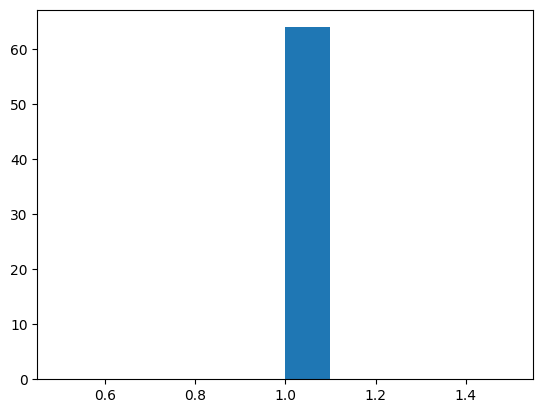

ups.0.1.net.3.bias Parameter


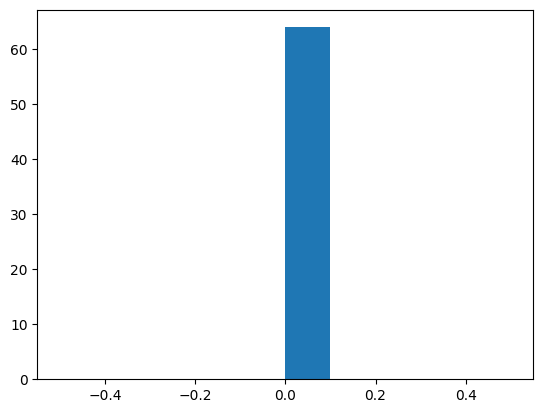

ups.0.1.net.4.weight Parameter


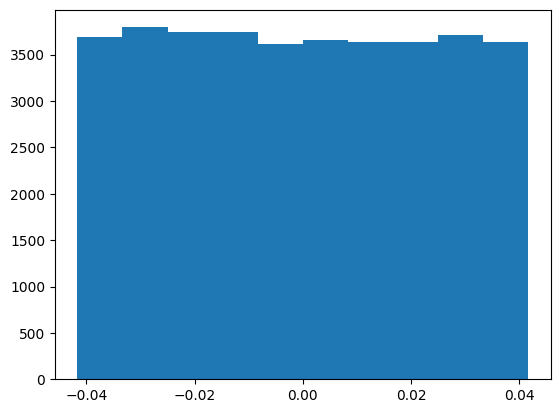

ups.0.1.net.4.bias Parameter


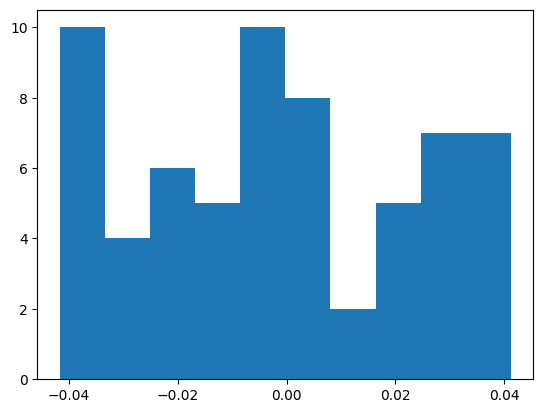

ups.0.2.fn.fn.to_qkv.weight Parameter


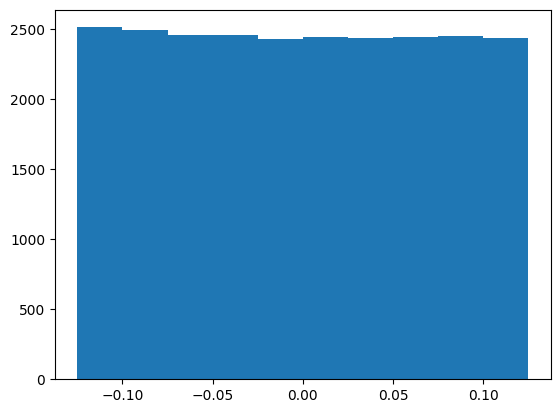

ups.0.2.fn.fn.to_out.0.weight Parameter


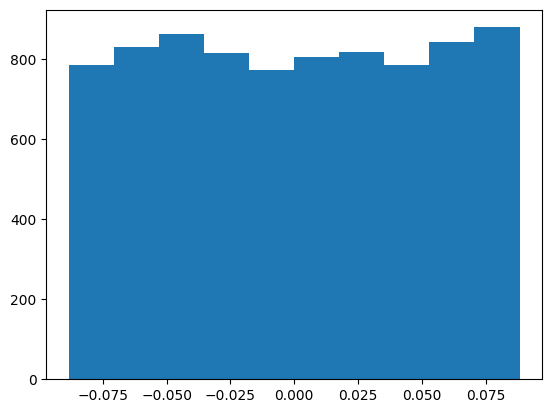

ups.0.2.fn.fn.to_out.0.bias Parameter


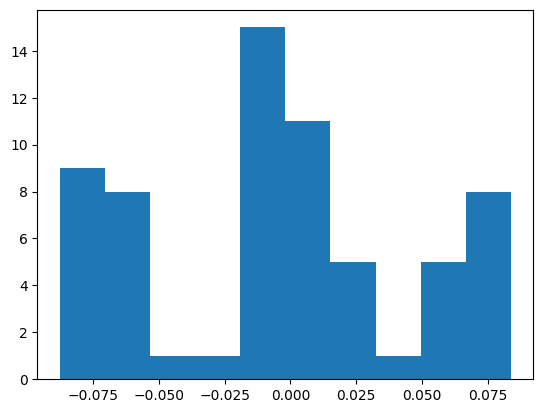

ups.0.2.fn.fn.to_out.1.weight Parameter


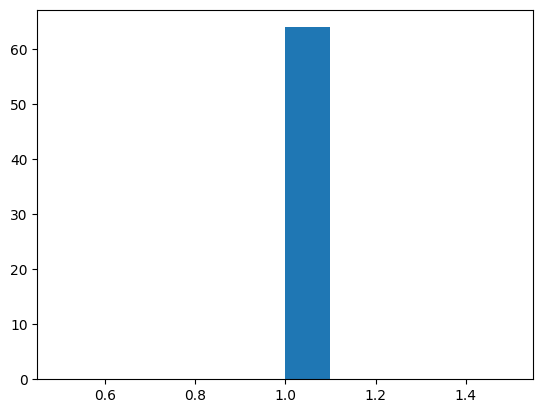

ups.0.2.fn.fn.to_out.1.bias Parameter


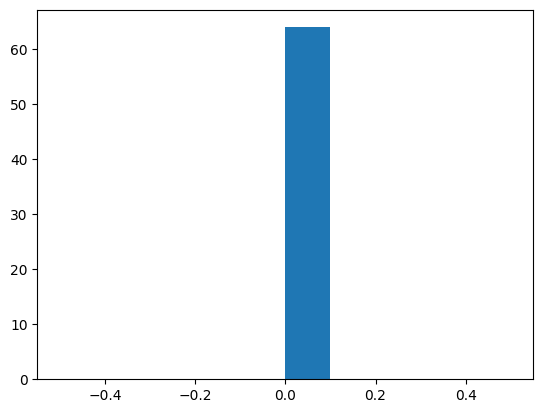

ups.0.2.fn.norm.weight Parameter


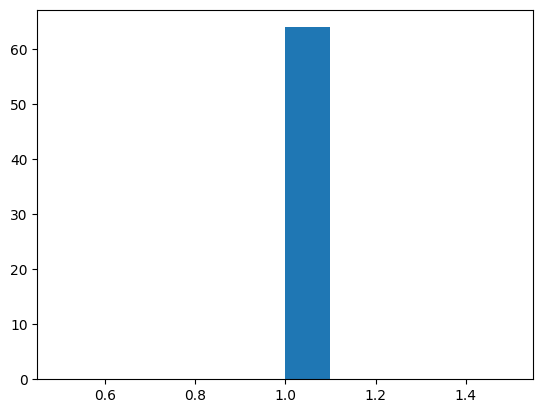

ups.0.2.fn.norm.bias Parameter


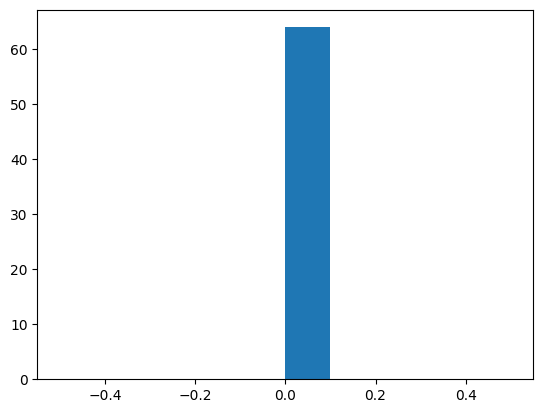

ups.0.3.weight Parameter


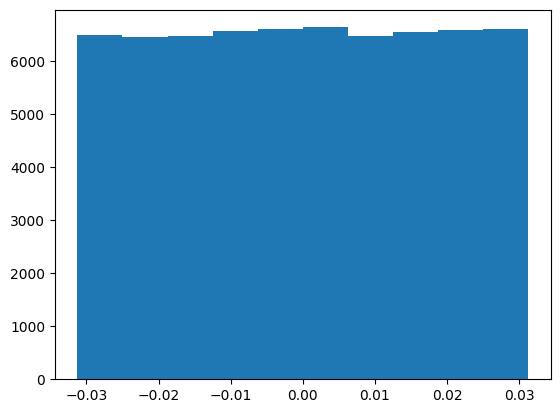

ups.0.3.bias Parameter


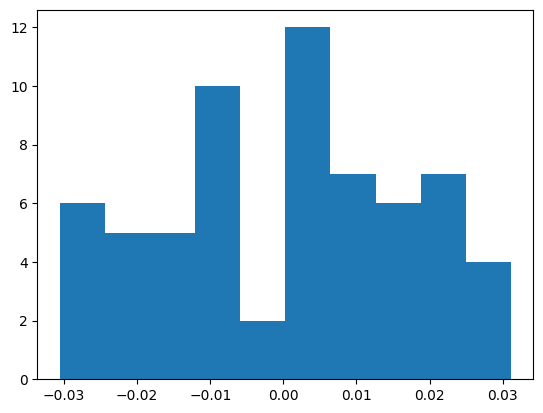

ups.1.0.ds_conv.weight Parameter


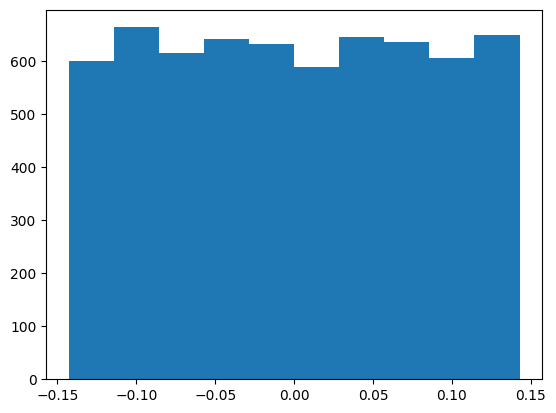

ups.1.0.ds_conv.bias Parameter


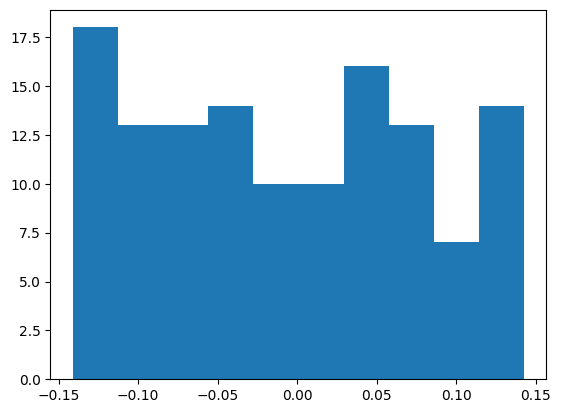

ups.1.0.net.0.weight Parameter


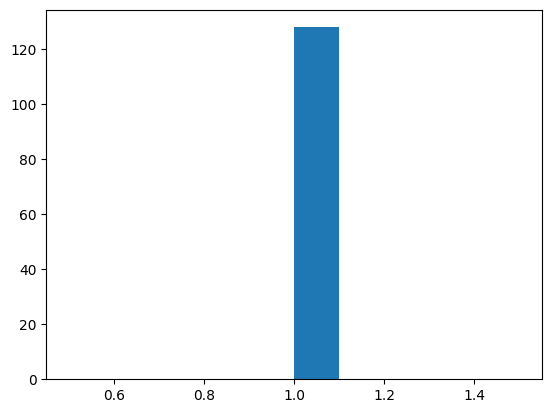

ups.1.0.net.0.bias Parameter


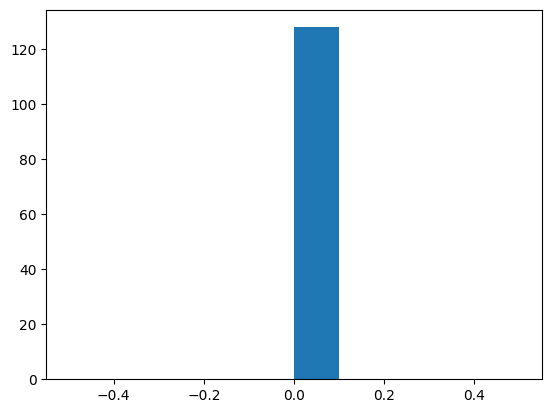

ups.1.0.net.1.weight Parameter


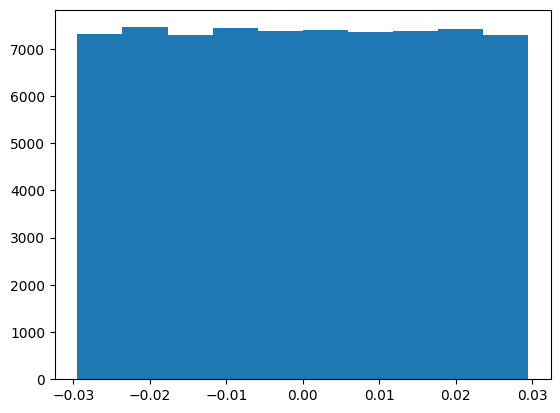

ups.1.0.net.1.bias Parameter


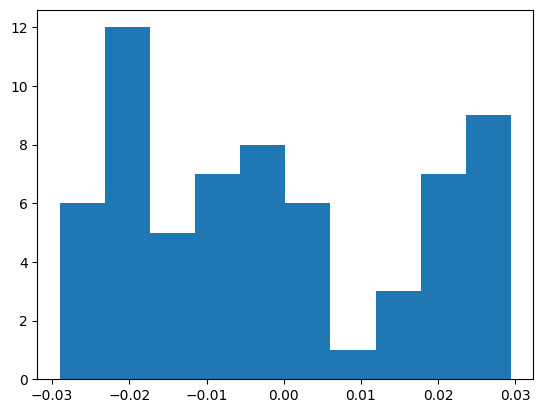

ups.1.0.net.3.weight Parameter


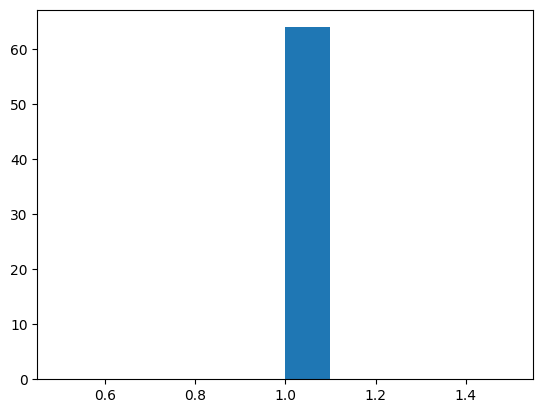

ups.1.0.net.3.bias Parameter


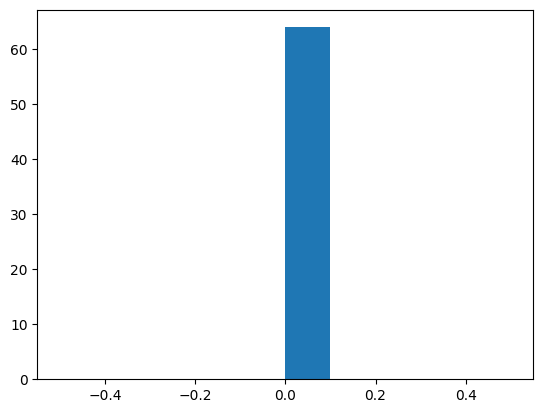

ups.1.0.net.4.weight Parameter


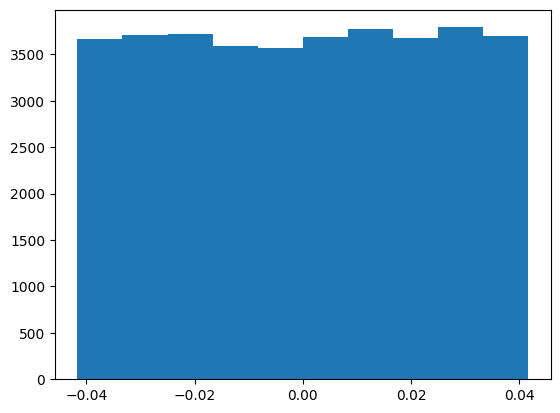

ups.1.0.net.4.bias Parameter


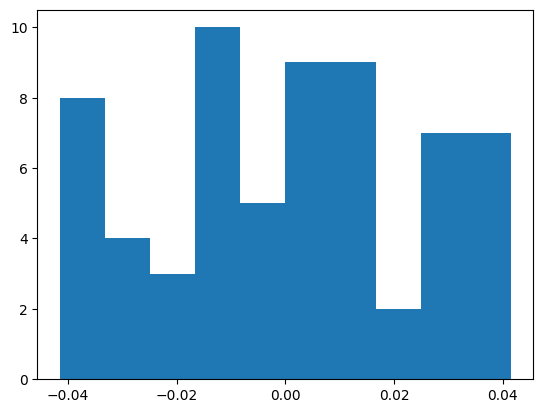

ups.1.0.res_conv.weight Parameter


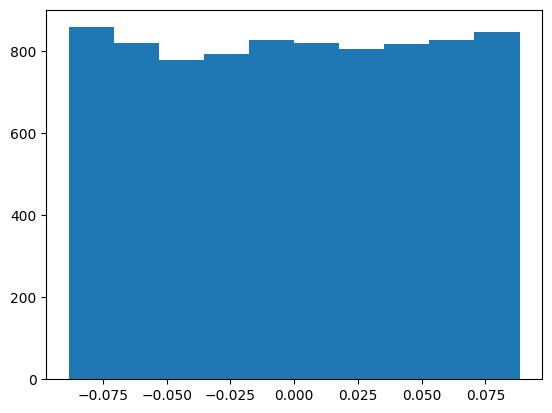

ups.1.0.res_conv.bias Parameter


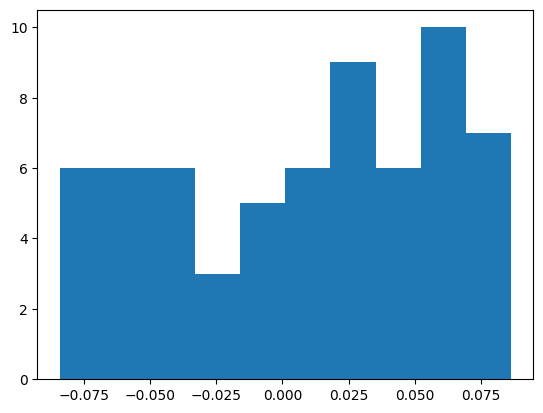

ups.1.1.ds_conv.weight Parameter


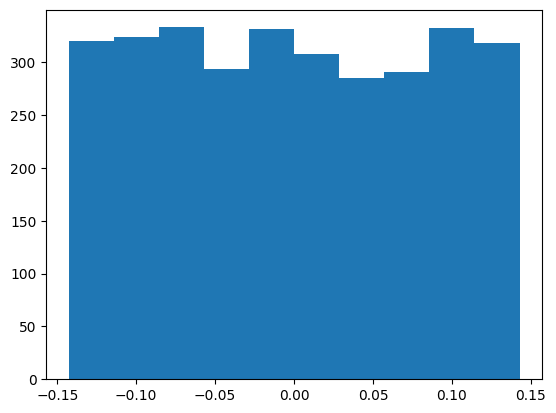

ups.1.1.ds_conv.bias Parameter


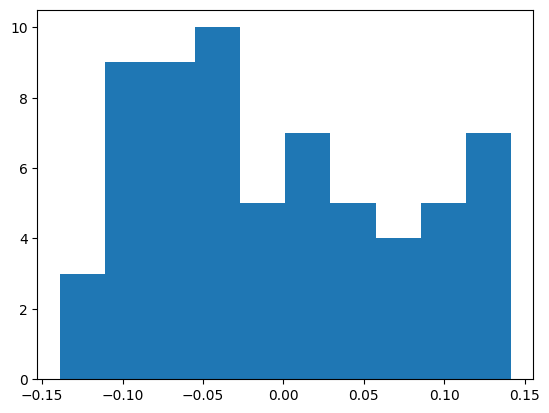

ups.1.1.net.0.weight Parameter


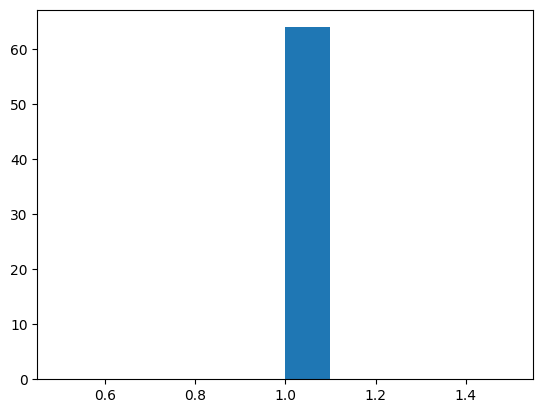

ups.1.1.net.0.bias Parameter


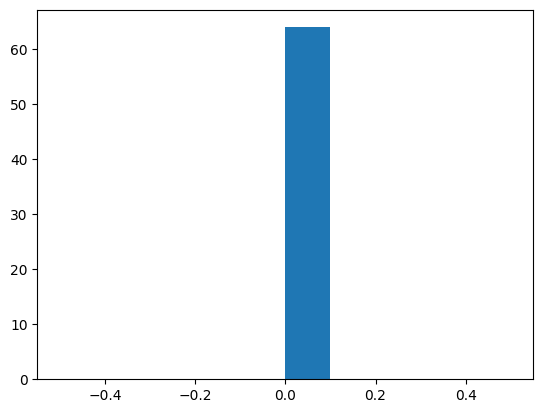

ups.1.1.net.1.weight Parameter


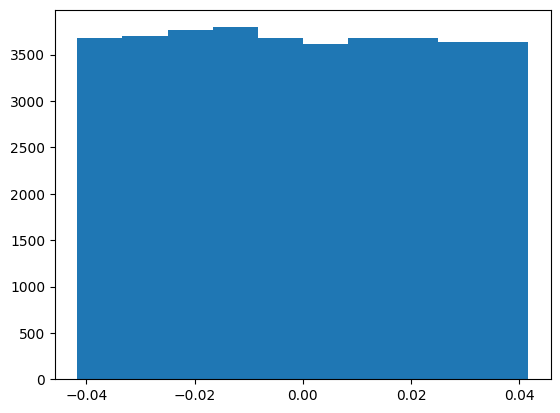

ups.1.1.net.1.bias Parameter


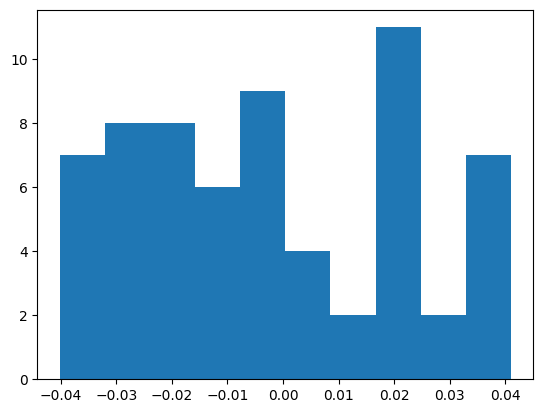

ups.1.1.net.3.weight Parameter


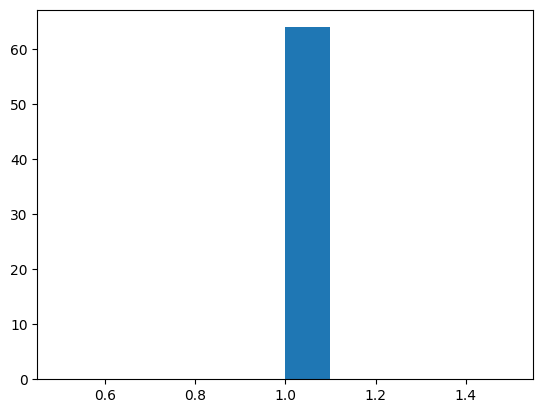

ups.1.1.net.3.bias Parameter


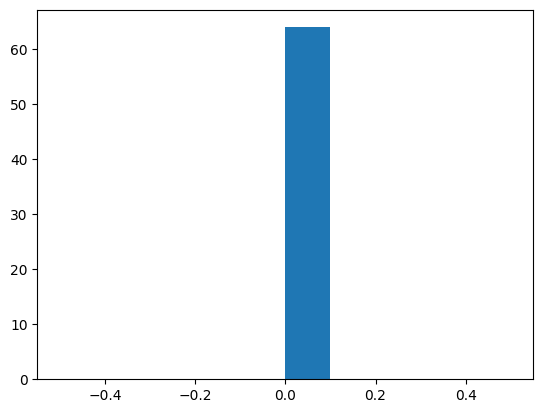

ups.1.1.net.4.weight Parameter


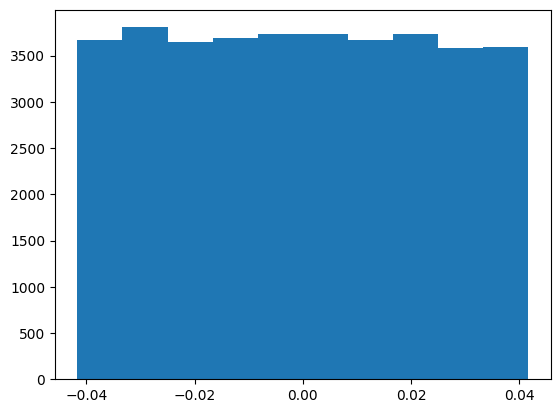

ups.1.1.net.4.bias Parameter


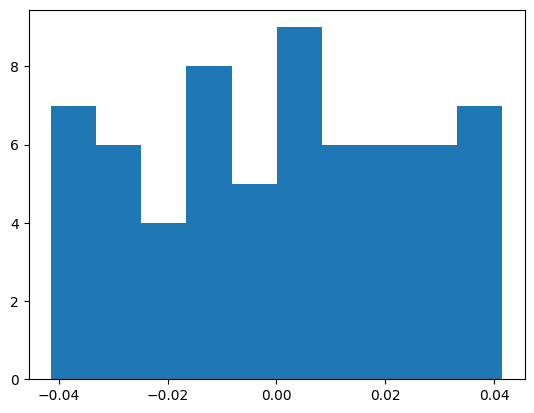

ups.1.2.fn.fn.to_qkv.weight Parameter


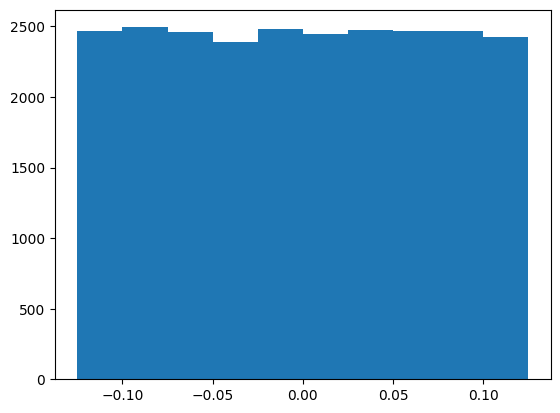

ups.1.2.fn.fn.to_out.0.weight Parameter


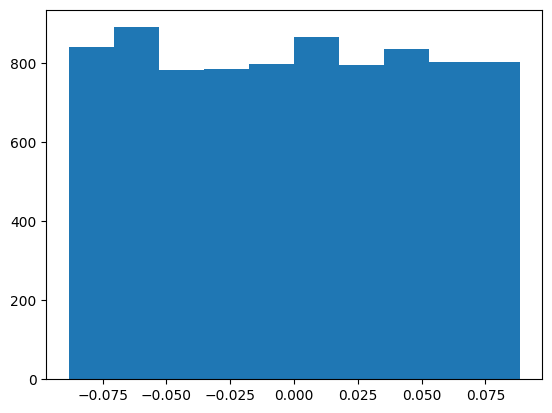

ups.1.2.fn.fn.to_out.0.bias Parameter


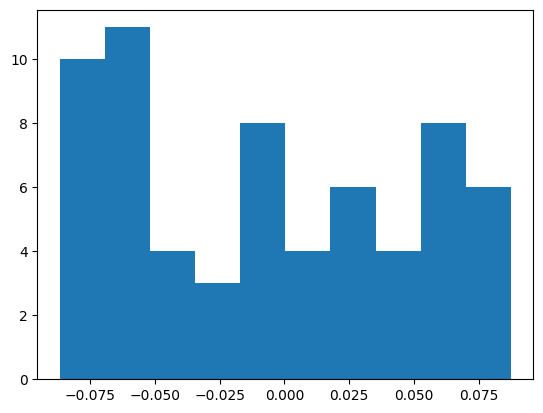

ups.1.2.fn.fn.to_out.1.weight Parameter


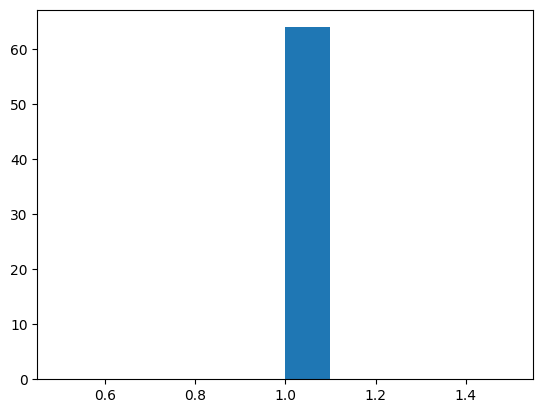

ups.1.2.fn.fn.to_out.1.bias Parameter


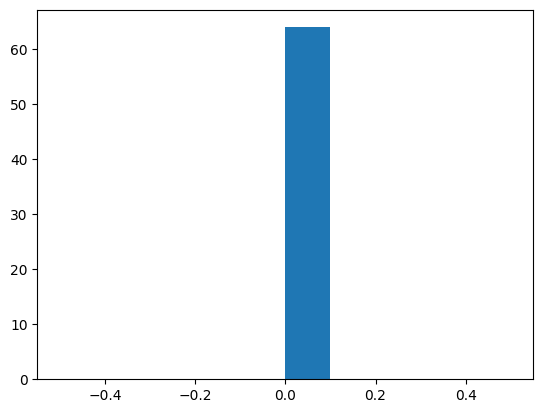

ups.1.2.fn.norm.weight Parameter


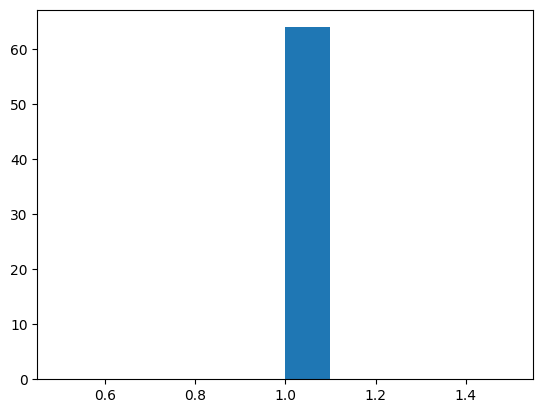

ups.1.2.fn.norm.bias Parameter


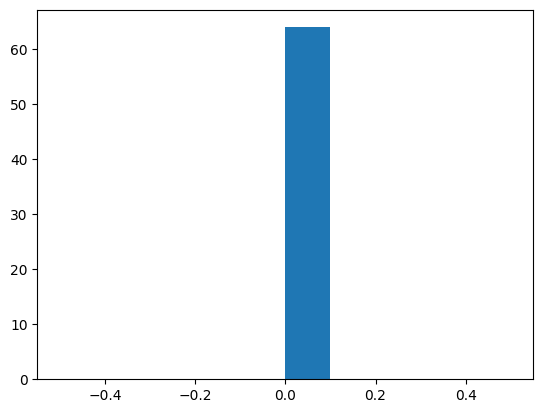

ups.1.3.weight Parameter


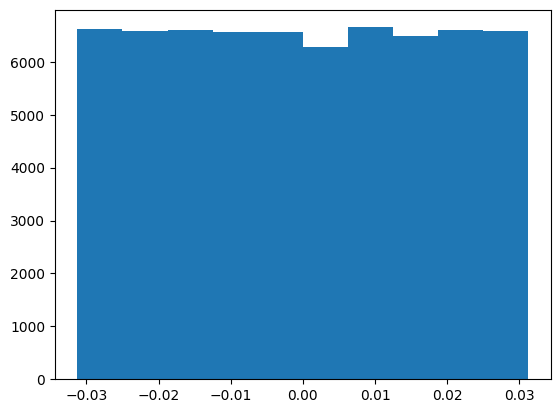

ups.1.3.bias Parameter


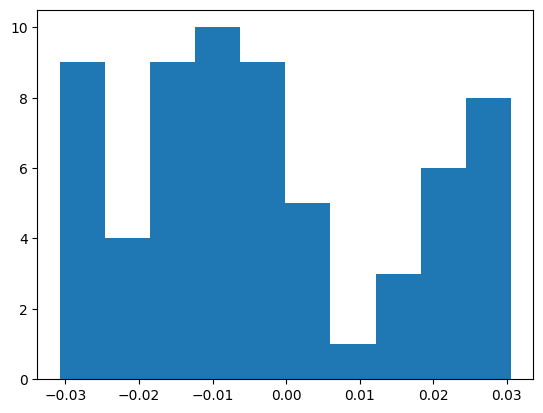

mid_block1.ds_conv.weight Parameter


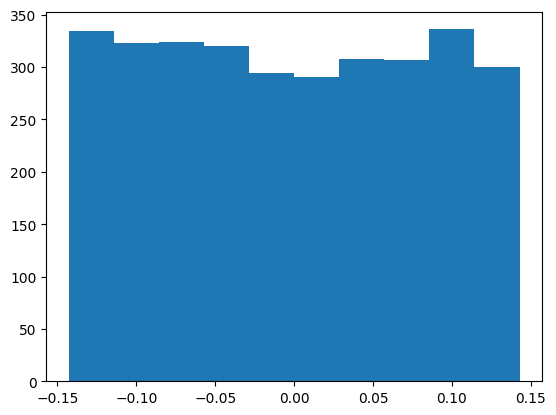

mid_block1.ds_conv.bias Parameter


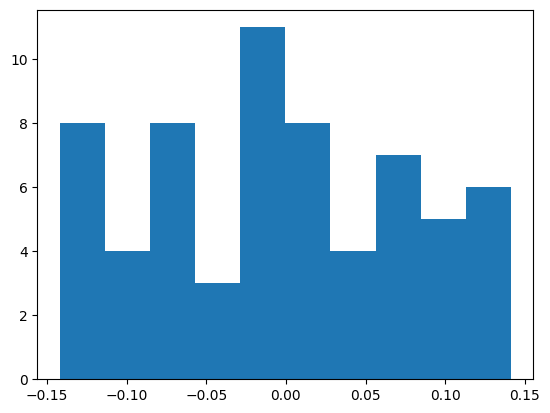

mid_block1.net.0.weight Parameter


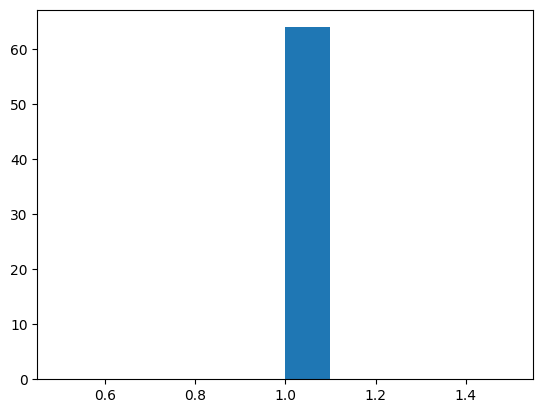

mid_block1.net.0.bias Parameter


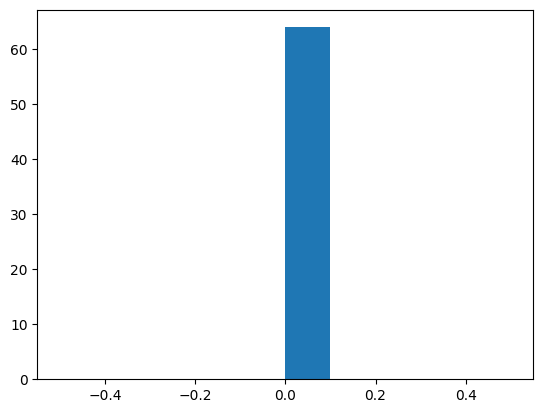

mid_block1.net.1.weight Parameter


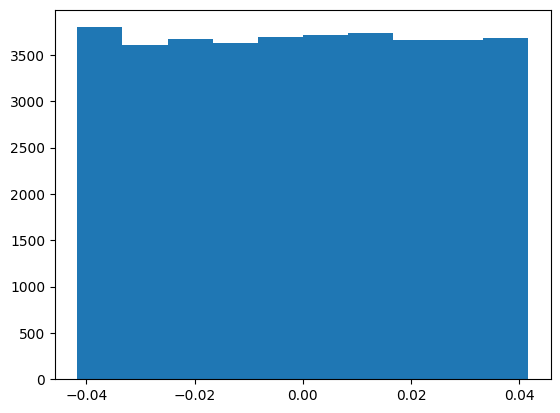

mid_block1.net.1.bias Parameter


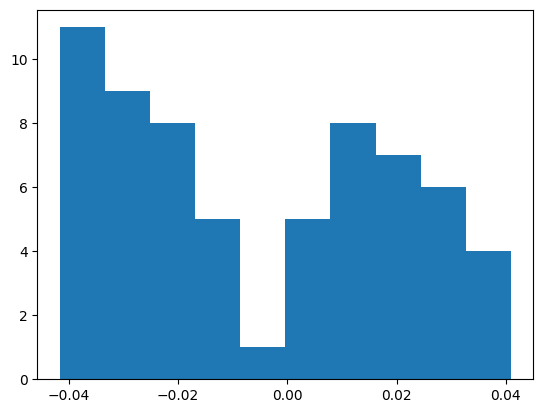

mid_block1.net.3.weight Parameter


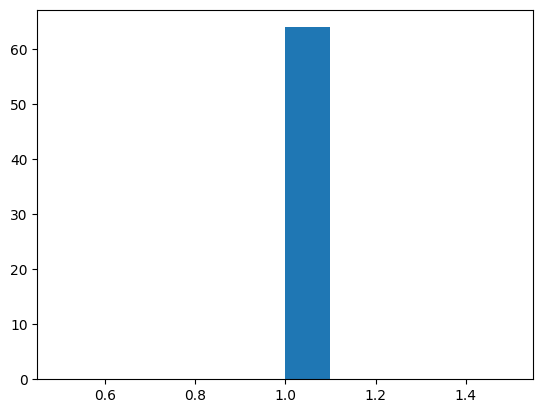

mid_block1.net.3.bias Parameter


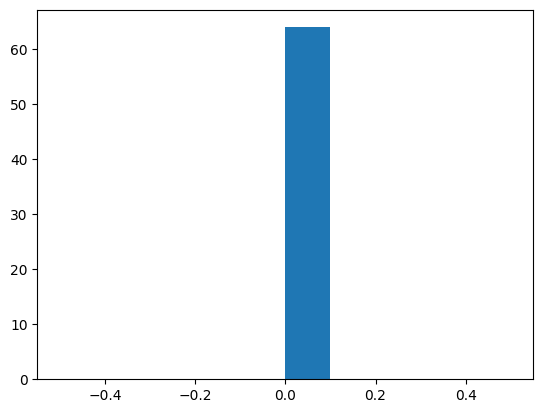

mid_block1.net.4.weight Parameter


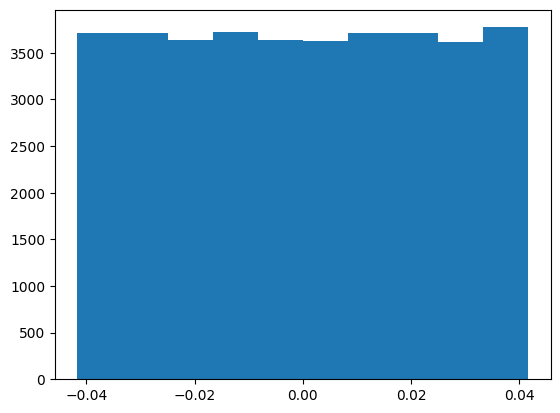

mid_block1.net.4.bias Parameter


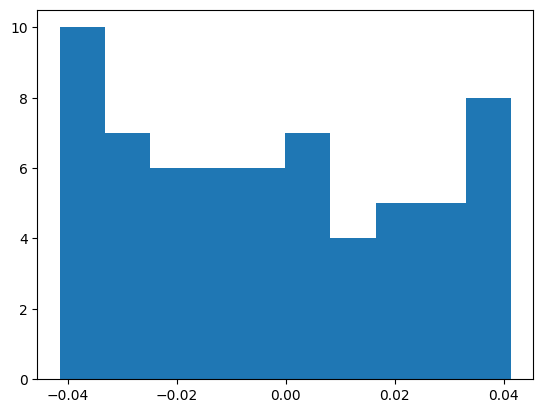

mid_attn.fn.fn.to_qkv.weight Parameter


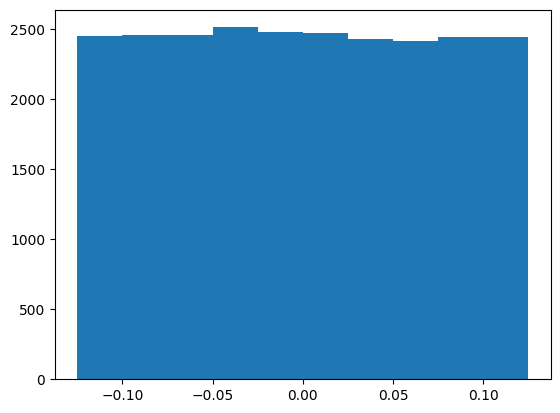

mid_attn.fn.fn.to_out.weight Parameter


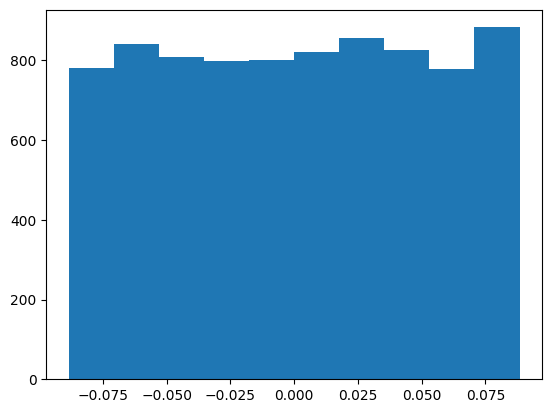

mid_attn.fn.fn.to_out.bias Parameter


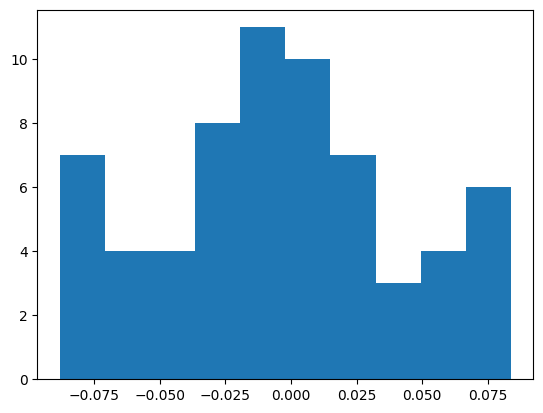

mid_attn.fn.norm.weight Parameter


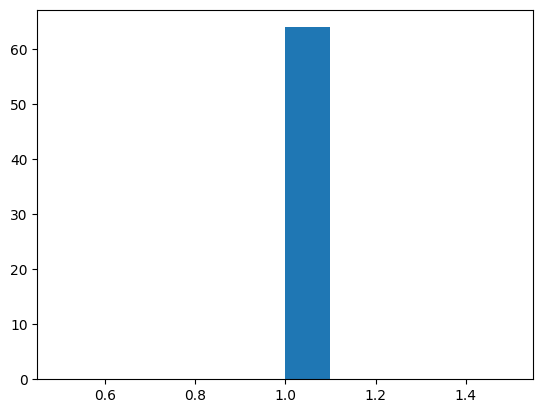

mid_attn.fn.norm.bias Parameter


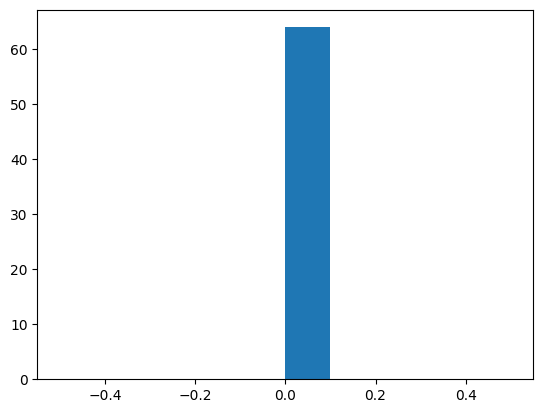

mid_block2.ds_conv.weight Parameter


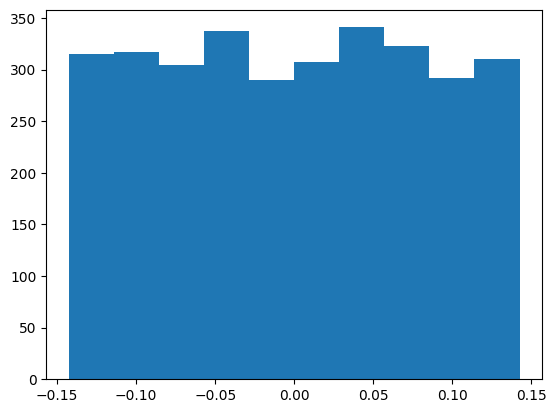

mid_block2.ds_conv.bias Parameter


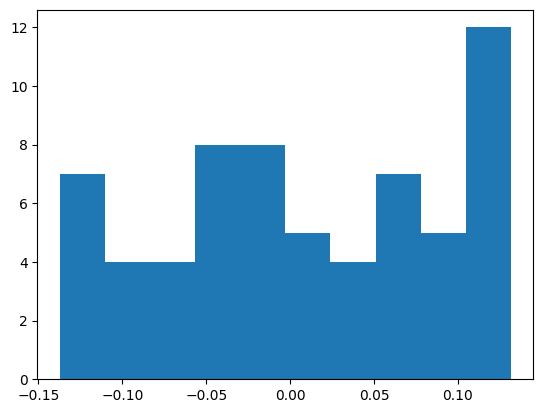

mid_block2.net.0.weight Parameter


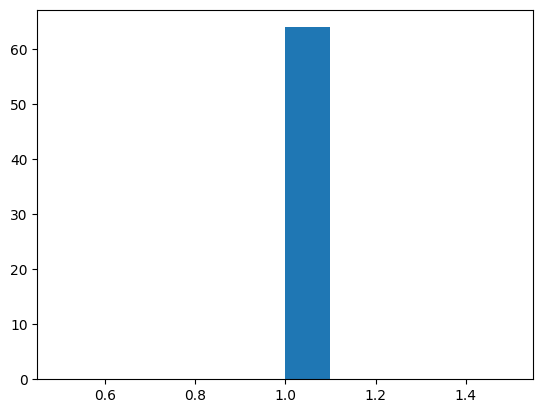

mid_block2.net.0.bias Parameter


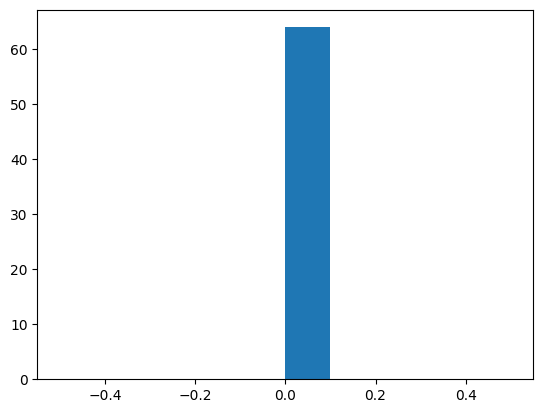

mid_block2.net.1.weight Parameter


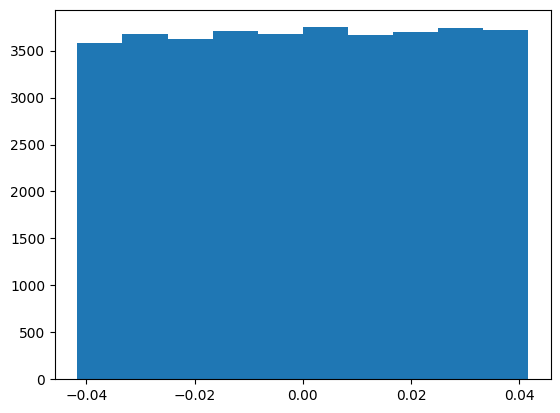

mid_block2.net.1.bias Parameter


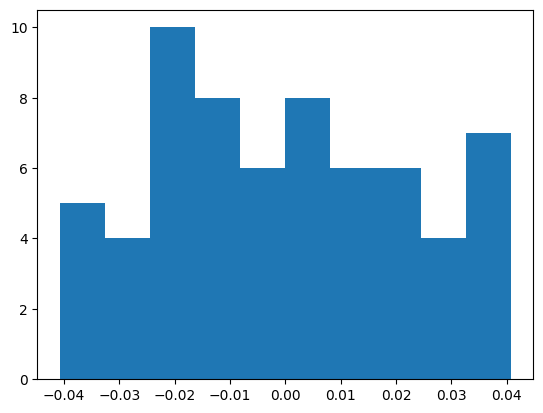

mid_block2.net.3.weight Parameter


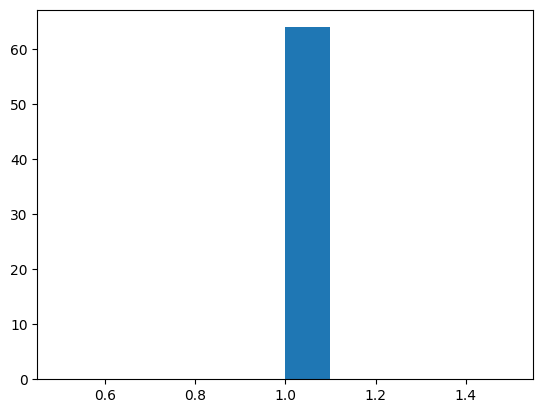

mid_block2.net.3.bias Parameter


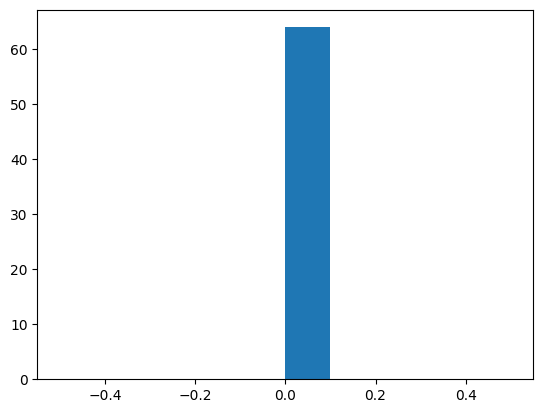

mid_block2.net.4.weight Parameter


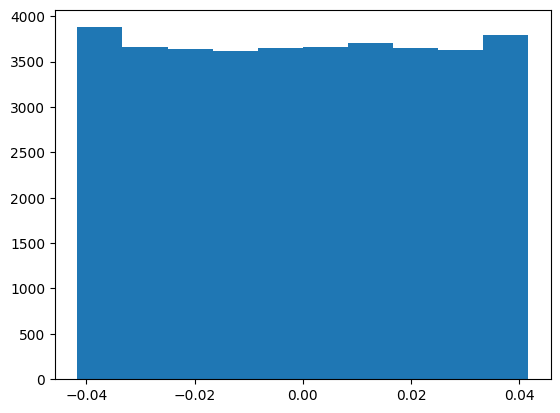

mid_block2.net.4.bias Parameter


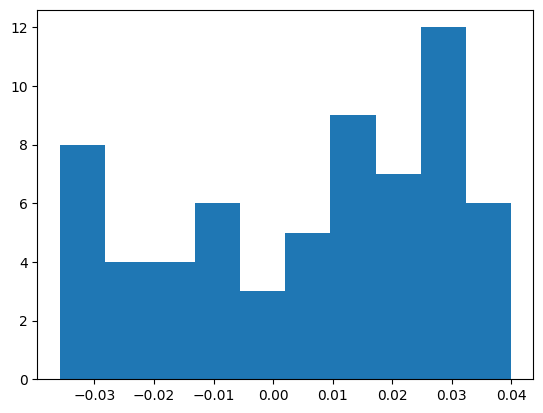

final_conv.0.ds_conv.weight Parameter


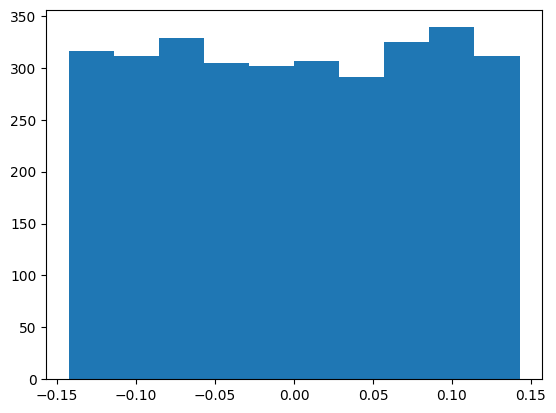

final_conv.0.ds_conv.bias Parameter


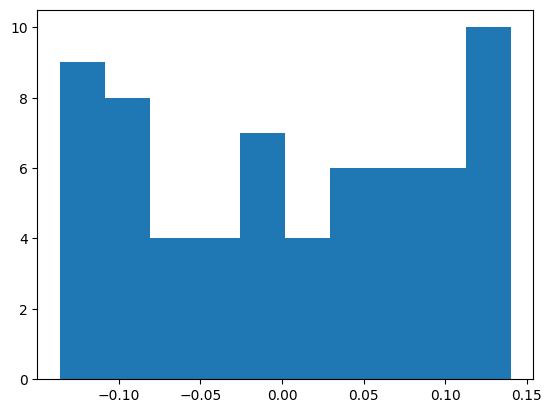

final_conv.0.net.0.weight Parameter


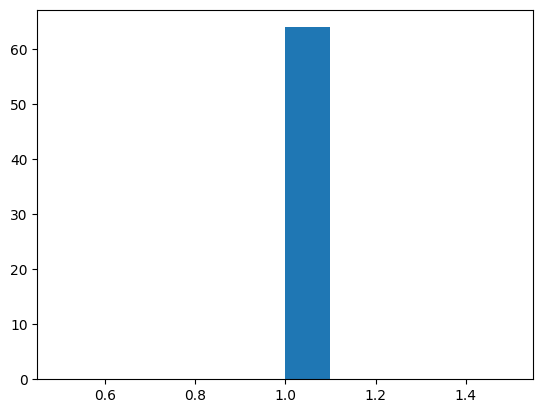

final_conv.0.net.0.bias Parameter


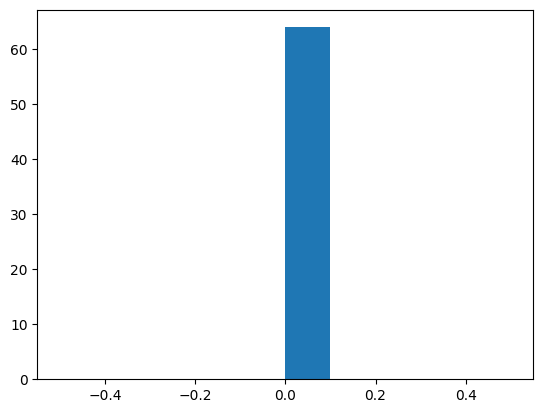

final_conv.0.net.1.weight Parameter


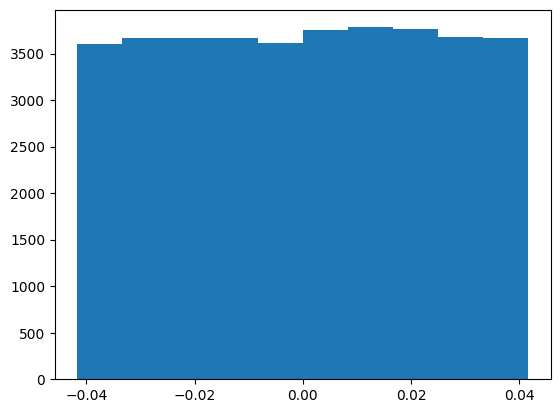

final_conv.0.net.1.bias Parameter


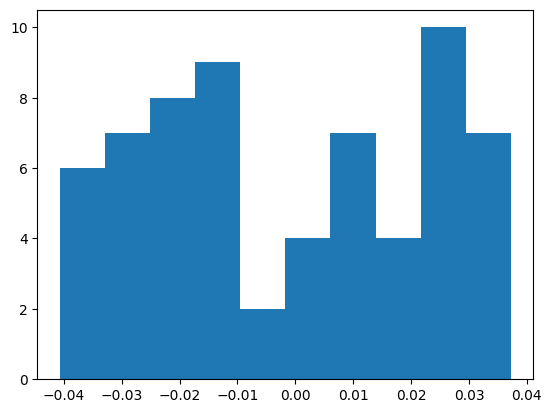

final_conv.0.net.3.weight Parameter


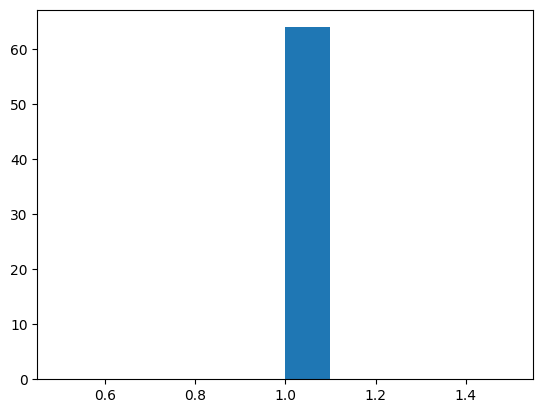

final_conv.0.net.3.bias Parameter


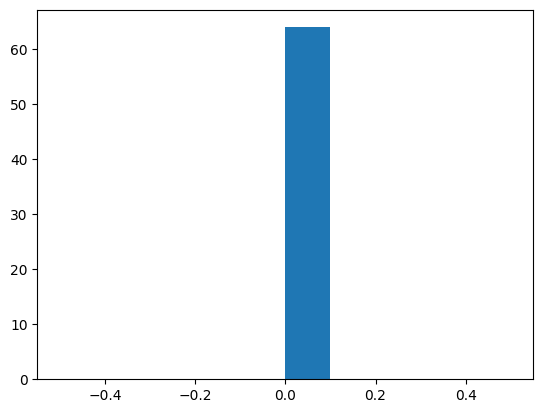

final_conv.0.net.4.weight Parameter


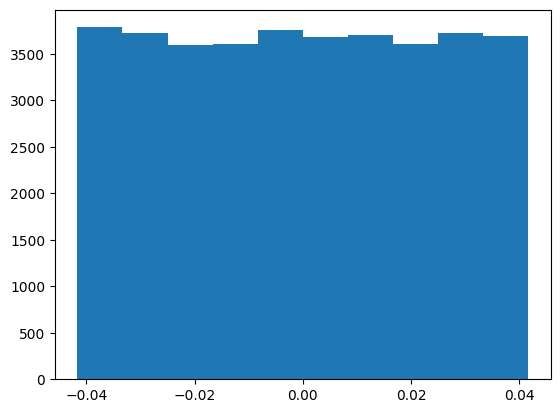

final_conv.0.net.4.bias Parameter


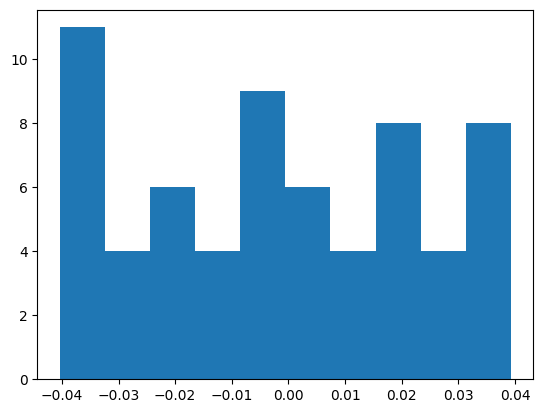

final_conv.1.weight Parameter


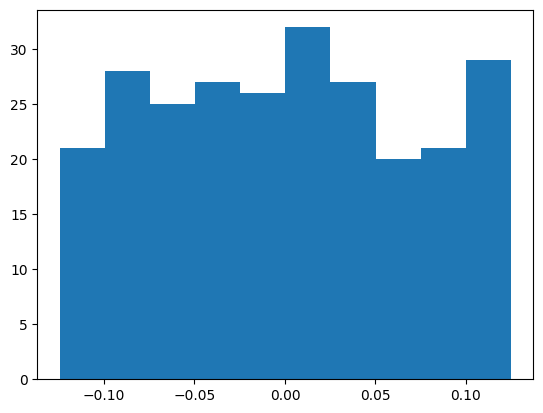

final_conv.1.bias Parameter


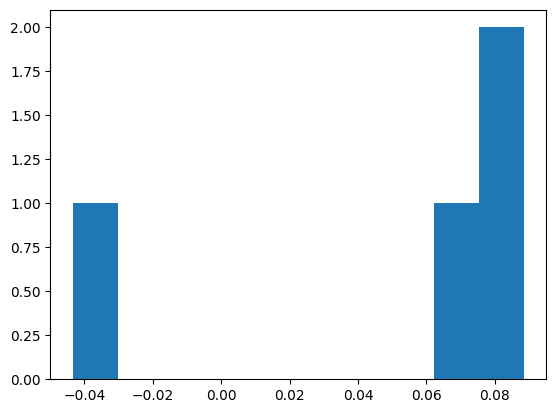

In [34]:
for name, p in model_prova.named_parameters():
    print(name, type(p).__name__)

    plt.hist(p.detach().flatten())
    plt.show()

# Testing

In [54]:
data_folder = "../data"

testSets = {
    "lowRey":
        TurbulenceDataset("Test Low Reynolds 100-200", [data_folder], filterTop=["128_inc"], filterSim=[[82,84,86,88,90]],
                filterFrame=[(1000,1150)], sequenceLength=[[60,2]], simFields=p_d.simFields, simParams=p_d.simParams, printLevel="sim"),
    "highRey" :
        TurbulenceDataset("Test High Reynolds 900-1000", [data_folder], filterTop=["128_inc"], filterSim=[[0,2,4,6,8]],
                filterFrame=[(1000,1150)], sequenceLength=[[60,2]], simFields=p_d.simFields, simParams=p_d.simParams, printLevel="sim"),
    "varReyIn" :
        TurbulenceDataset("Test Varying Reynolds Number (200-900)", [data_folder], filterTop=["128_reyVar"], filterSim=[[0]],
                filterFrame=[(300,800)], sequenceLength=[[250,2]], simFields=p_d.simFields, simParams=p_d.simParams, printLevel="sim"),
}

In [ ]:
testers = []
testHistories = []
for shortName, testSet in testSets.items():
    p_d_test = copy.deepcopy(p_d)
    p_d_test.augmentations = ["normalize"]
    p_d_test.sequenceLength = testSet.sequenceLength
    p_d_test.randSeqOffset = False
    if p_d.sequenceLength[0] != p_d_test.sequenceLength[0]:
        p_d_test.batch = 1

    transTest = Transforms(p_d_test)
    testSet.transform = transTest
    testSet.printDatasetInfo()
    testSampler = SequentialSampler(testSet)
    #testSampler = SubsetRandomSampler(range(2))
    testLoader = DataLoader(testSet, sampler=testSampler,
                    batch_size=p_d_test.batch, drop_last=False, num_workers=4)
    testHistory = LossHistory(shortName, testSet.name, logger.tfWriter, len(testLoader),
                                100, 100, printInterval=0, logInterval=0, simFields=p_d.simFields)
    tester = Tester(model, testLoader, criterion, testHistory, p_t)
    testers += [tester]
    testHistories += [testHistory]